<a href="https://colab.research.google.com/github/ngzhiwei517/TM-113/blob/main/TM_113_Datathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement**

How can we build a solution that carefully interprets
the patterns hidden in a baby’s heart rate and the
mother’s contractions, in order to automatically
identify signs of fetal distress that might otherwise
go unnoticed during labor?

# Consolidate Imports

In [318]:
# Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (balanced_accuracy_score, f1_score,
                            classification_report, confusion_matrix)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_sample_weight

# XGBoost
from xgboost import XGBClassifier

# SHAP
import shap

# Settings
import warnings
warnings.filterwarnings('ignore')

# Configuration


In [319]:
# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Model hyperparameters
XGBOOST_PARAMS = {
    'n_estimators': 200,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 1,
    'min_child_weight': 3,
    'random_state': RANDOM_STATE,
    'eval_metric': 'mlogloss',
    'use_label_encoder': False
}

RF_PARAMS = {
    'n_estimators': 200,
    'max_depth': 20,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'class_weight': 'balanced',
    'random_state': RANDOM_STATE,
    'n_jobs': -1
}

# Train-test split ratio
TEST_SIZE = 0.2

# 1.1 Data Loading and Cleaning


Removing errors, inconsistencies, and fixing broken data



In [320]:
# Importing lake dataset
CTG_df=pd.read_csv("/content/CTG_original_3.csv")


Let have a look for our dataset

In [321]:
CTG_df

,FileName,Date,SegFile,b,e,LBE,LB,AC,FM,UC,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Variab10.txt,1/12/1996,CTG0001.txt,240.0,357.0,120.0,120.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,2.0
2,Fmcs_1.txt,3/5/1996,CTG0002.txt,5.0,632.0,132.0,132.0,4.0,0.0,4.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
3,Fmcs_1.txt,3/5/1996,CTG0003.txt,177.0,779.0,133.0,133.0,2.0,0.0,5.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
4,Fmcs_1.txt,3/5/1996,CTG0004.txt,411.0,1192.0,134.0,134.0,2.0,0.0,6.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2125,S8001045.dsp,6/6/1998,CTG2127.txt,1576.0,3049.0,140.0,140.0,1.0,0.0,9.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
2126,S8001045.dsp,6/6/1998,CTG2128.txt,2796.0,3415.0,142.0,142.0,1.0,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Since the first row is all NAN and it is not useful for our analysis, let drop it

In [322]:
CTG_df = CTG_df.dropna(how='all')  # Remove rows where ALL values are NaN
print("After dropping empty rows:", CTG_df.shape)

After dropping empty rows: (2128, 40)




*   Originally, there were 2130 rows and 40 columns.
*   During cleaning, 3 rows containing NaN (missing values) were dropped.



In [323]:
print("\nColumn names:\n", CTG_df.columns.tolist())
print("\nData types:\n", CTG_df.dtypes)


Column names:
 ['FileName', 'Date', 'SegFile', 'b', 'e', 'LBE', 'LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'DS', 'DP', 'DR', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median', 'Variance', 'Tendency', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP', 'CLASS', 'NSP']

Data types:
 FileName     object
Date         object
SegFile      object
b           float64
e           float64
LBE         float64
LB          float64
AC          float64
FM          float64
UC          float64
ASTV        float64
MSTV        float64
ALTV        float64
MLTV        float64
DL          float64
DS          float64
DP          float64
DR          float64
Width       float64
Min         float64
Max         float64
Nmax        float64
Nzeros      float64
Mode        float64
Mean        float64
Median      float64
Variance    float64
Tendency    float64
A           float64
B           float64
C           float64
D           float64
E           float64
AD          float

FileName, Date, and SegFile are just metadata - not useful for prediction

# 1.1.1 Drop metadata

In [324]:
# Drop object type columns (metadata)
columns_to_drop = ['FileName', 'Date', 'SegFile']
df = CTG_df.drop(columns=columns_to_drop)

print("After dropping metadata:", df.shape)
print("\nRemaining columns:")
print(df.columns.tolist())

After dropping metadata: (2128, 37)

Remaining columns:
['b', 'e', 'LBE', 'LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'DS', 'DP', 'DR', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median', 'Variance', 'Tendency', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP', 'CLASS', 'NSP']


# 1.1.2 Overview of dataset

In [325]:
# Checking data
print("\nInformation of the dataset")
print(df.info())


Information of the dataset
<class 'pandas.core.frame.DataFrame'>
Index: 2128 entries, 1 to 2129
Data columns (total 37 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   b         2126 non-null   float64
 1   e         2126 non-null   float64
 2   LBE       2126 non-null   float64
 3   LB        2126 non-null   float64
 4   AC        2126 non-null   float64
 5   FM        2127 non-null   float64
 6   UC        2127 non-null   float64
 7   ASTV      2127 non-null   float64
 8   MSTV      2127 non-null   float64
 9   ALTV      2127 non-null   float64
 10  MLTV      2127 non-null   float64
 11  DL        2128 non-null   float64
 12  DS        2128 non-null   float64
 13  DP        2128 non-null   float64
 14  DR        2128 non-null   float64
 15  Width     2126 non-null   float64
 16  Min       2126 non-null   float64
 17  Max       2126 non-null   float64
 18  Nmax      2126 non-null   float64
 19  Nzeros    2126 non-null   float64
 20  Mode   

In [326]:
print("\nNumber of unique value for each column")
print(df.nunique())


Number of unique value for each column
b            979
e           1064
LBE           48
LB            48
AC            22
FM            96
UC            19
ASTV          75
MSTV          57
ALTV          87
MLTV         249
DL            15
DS             2
DP             5
DR             1
Width        154
Min          109
Max           86
Nmax          18
Nzeros         9
Mode          88
Mean         103
Median        95
Variance     133
Tendency       3
A              2
B              2
C              2
D              2
E              2
AD             2
DE             2
LD             2
FS             2
SUSP           2
CLASS         10
NSP            3
dtype: int64


In [327]:
print(f'The dateset has {df.shape[0]} rows and {df.shape[1]} columns.')

The dateset has 2128 rows and 37 columns.


# 1.1.3 Check for missing values for each column

In [328]:
print("\nFind missing value of each column")
print(df.isna().sum())


Find missing value of each column
b           2
e           2
LBE         2
LB          2
AC          2
FM          1
UC          1
ASTV        1
MSTV        1
ALTV        1
MLTV        1
DL          0
DS          0
DP          0
DR          0
Width       2
Min         2
Max         2
Nmax        2
Nzeros      2
Mode        2
Mean        2
Median      2
Variance    2
Tendency    2
A           2
B           2
C           2
D           2
E           2
AD          2
DE          2
LD          2
FS          2
SUSP        2
CLASS       2
NSP         2
dtype: int64


Since we have very few missing values per column (most = 2, some = 1).

In a dataset of ~2128 rows, that’s 0.09-0.19% loss . So we decide to drop rows instead of filling the missing values.



*   We still have 2126+ rows: More than enough for training!

In [329]:
print("\nRemove all rows with missing data by using dropna()")
df = df.dropna ()
print(df.isna().sum())


Remove all rows with missing data by using dropna()
b           0
e           0
LBE         0
LB          0
AC          0
FM          0
UC          0
ASTV        0
MSTV        0
ALTV        0
MLTV        0
DL          0
DS          0
DP          0
DR          0
Width       0
Min         0
Max         0
Nmax        0
Nzeros      0
Mode        0
Mean        0
Median      0
Variance    0
Tendency    0
A           0
B           0
C           0
D           0
E           0
AD          0
DE          0
LD          0
FS          0
SUSP        0
CLASS       0
NSP         0
dtype: int64


We had sucessfully remove all the missing data

In [330]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2126 entries, 1 to 2126
Data columns (total 37 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   b         2126 non-null   float64
 1   e         2126 non-null   float64
 2   LBE       2126 non-null   float64
 3   LB        2126 non-null   float64
 4   AC        2126 non-null   float64
 5   FM        2126 non-null   float64
 6   UC        2126 non-null   float64
 7   ASTV      2126 non-null   float64
 8   MSTV      2126 non-null   float64
 9   ALTV      2126 non-null   float64
 10  MLTV      2126 non-null   float64
 11  DL        2126 non-null   float64
 12  DS        2126 non-null   float64
 13  DP        2126 non-null   float64
 14  DR        2126 non-null   float64
 15  Width     2126 non-null   float64
 16  Min       2126 non-null   float64
 17  Max       2126 non-null   float64
 18  Nmax      2126 non-null   float64
 19  Nzeros    2126 non-null   float64
 20  Mode      2126 non-null   float64
 

# 1.1.4 Identify and handle duplicate value

**Count duplicate row**

In [331]:
df.duplicated().sum()

np.int64(10)

We found 10 duplicate rows in the dataset.

**Show all the duplicate rows**

In [332]:
duplicates_all = df[df.duplicated(keep=False)]
print(duplicates_all)

           b       e    LBE     LB   AC    FM   UC  ASTV  MSTV  ALTV  ...  \
68      10.0   697.0  140.0  140.0  5.0   0.0  3.0  34.0   1.2   0.0  ...   
69      10.0   697.0  140.0  140.0  5.0   0.0  3.0  34.0   1.2   0.0  ...   
230      0.0  1199.0  123.0  123.0  3.0   4.0  0.0  52.0   0.8   2.0  ...   
234    276.0   596.0  123.0  123.0  0.0   0.0  0.0  49.0   0.8   7.0  ...   
235    276.0   596.0  123.0  123.0  0.0   0.0  0.0  49.0   0.8   7.0  ...   
324    179.0   666.0  135.0  135.0  0.0   0.0  0.0  62.0   0.5  71.0  ...   
325    179.0   666.0  135.0  135.0  0.0   0.0  0.0  62.0   0.5  71.0  ...   
327      0.0   809.0  144.0  144.0  0.0  15.0  0.0  76.0   0.4  61.0  ...   
334      0.0   809.0  144.0  144.0  0.0  15.0  0.0  76.0   0.4  61.0  ...   
788      0.0  1199.0  123.0  123.0  3.0   4.0  0.0  52.0   0.8   2.0  ...   
791    176.0   928.0  123.0  123.0  2.0   3.0  0.0  50.0   0.9   4.0  ...   
792    176.0   928.0  123.0  123.0  2.0   3.0  0.0  50.0   0.9   4.0  ...   

In [333]:
#keep the first row show the other duplicate rows
df[df.duplicated()]

,b,e,LBE,LB,AC,FM,UC,ASTV,MSTV,ALTV,...,C,D,E,AD,DE,LD,FS,SUSP,CLASS,NSP
69,10.0,697.0,140.0,140.0,5.0,0.0,3.0,34.0,1.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
235,276.0,596.0,123.0,123.0,0.0,0.0,0.0,49.0,0.8,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
325,179.0,666.0,135.0,135.0,0.0,0.0,0.0,62.0,0.5,71.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,9.0,3.0
334,0.0,809.0,144.0,144.0,0.0,15.0,0.0,76.0,0.4,61.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,2.0
788,0.0,1199.0,123.0,123.0,3.0,4.0,0.0,52.0,0.8,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
792,176.0,928.0,123.0,123.0,2.0,3.0,0.0,50.0,0.9,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0
799,454.0,1853.0,146.0,146.0,0.0,0.0,4.0,65.0,0.4,39.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,2.0
1115,569.0,1320.0,122.0,122.0,0.0,0.0,0.0,19.0,1.9,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0
1116,569.0,1320.0,122.0,122.0,0.0,0.0,0.0,19.0,1.9,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0
1459,1544.0,1968.0,148.0,148.0,2.0,0.0,1.0,40.0,0.9,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0


**Drop duplicate rows, keep the first occurrence**

Using *drop_duplicates*, we removed the duplicates while retaining the first occurrence. This ensures each record is unique.”

In [334]:
df = df.drop_duplicates(keep="first")

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2116 entries, 1 to 2126
Data columns (total 37 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   b         2116 non-null   float64
 1   e         2116 non-null   float64
 2   LBE       2116 non-null   float64
 3   LB        2116 non-null   float64
 4   AC        2116 non-null   float64
 5   FM        2116 non-null   float64
 6   UC        2116 non-null   float64
 7   ASTV      2116 non-null   float64
 8   MSTV      2116 non-null   float64
 9   ALTV      2116 non-null   float64
 10  MLTV      2116 non-null   float64
 11  DL        2116 non-null   float64
 12  DS        2116 non-null   float64
 13  DP        2116 non-null   float64
 14  DR        2116 non-null   float64
 15  Width     2116 non-null   float64
 16  Min       2116 non-null   float64
 17  Max       2116 non-null   float64
 18  Nmax      2116 non-null   float64
 19  Nzeros    2116 non-null   float64
 20  Mode      2116 non-null   float64
 

# 1.1.5 Identify and changing incorrect data types

Since CLASS and NSP are categorical,but right now it shows as float, hence we would change it to categorical variables

In [335]:
df["CLASS"] = df["CLASS"].astype("category")
df["NSP"]   = df["NSP"].astype("category")

In [336]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2116 entries, 1 to 2126
Data columns (total 37 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   b         2116 non-null   float64 
 1   e         2116 non-null   float64 
 2   LBE       2116 non-null   float64 
 3   LB        2116 non-null   float64 
 4   AC        2116 non-null   float64 
 5   FM        2116 non-null   float64 
 6   UC        2116 non-null   float64 
 7   ASTV      2116 non-null   float64 
 8   MSTV      2116 non-null   float64 
 9   ALTV      2116 non-null   float64 
 10  MLTV      2116 non-null   float64 
 11  DL        2116 non-null   float64 
 12  DS        2116 non-null   float64 
 13  DP        2116 non-null   float64 
 14  DR        2116 non-null   float64 
 15  Width     2116 non-null   float64 
 16  Min       2116 non-null   float64 
 17  Max       2116 non-null   float64 
 18  Nmax      2116 non-null   float64 
 19  Nzeros    2116 non-null   float64 
 20  Mode      211

Our data cleaning pipeline included handling missing values, removing duplicate rows, checking for constant features and verifying datatypes,

# 2.1 Exploratory data analysis

Exploratory data analysis allows us to have a better understanding of the pattern of the dataset, spot anomalies, test hypothesis and check assumptions. It will ease our works when dealing with data preprocessing and model selection.

# 2.1.1 Target Variable (Label) Distribution


*   Count of Normal / Suspect / Pathologic.
*   Plot bar chart → check for class imbalance.



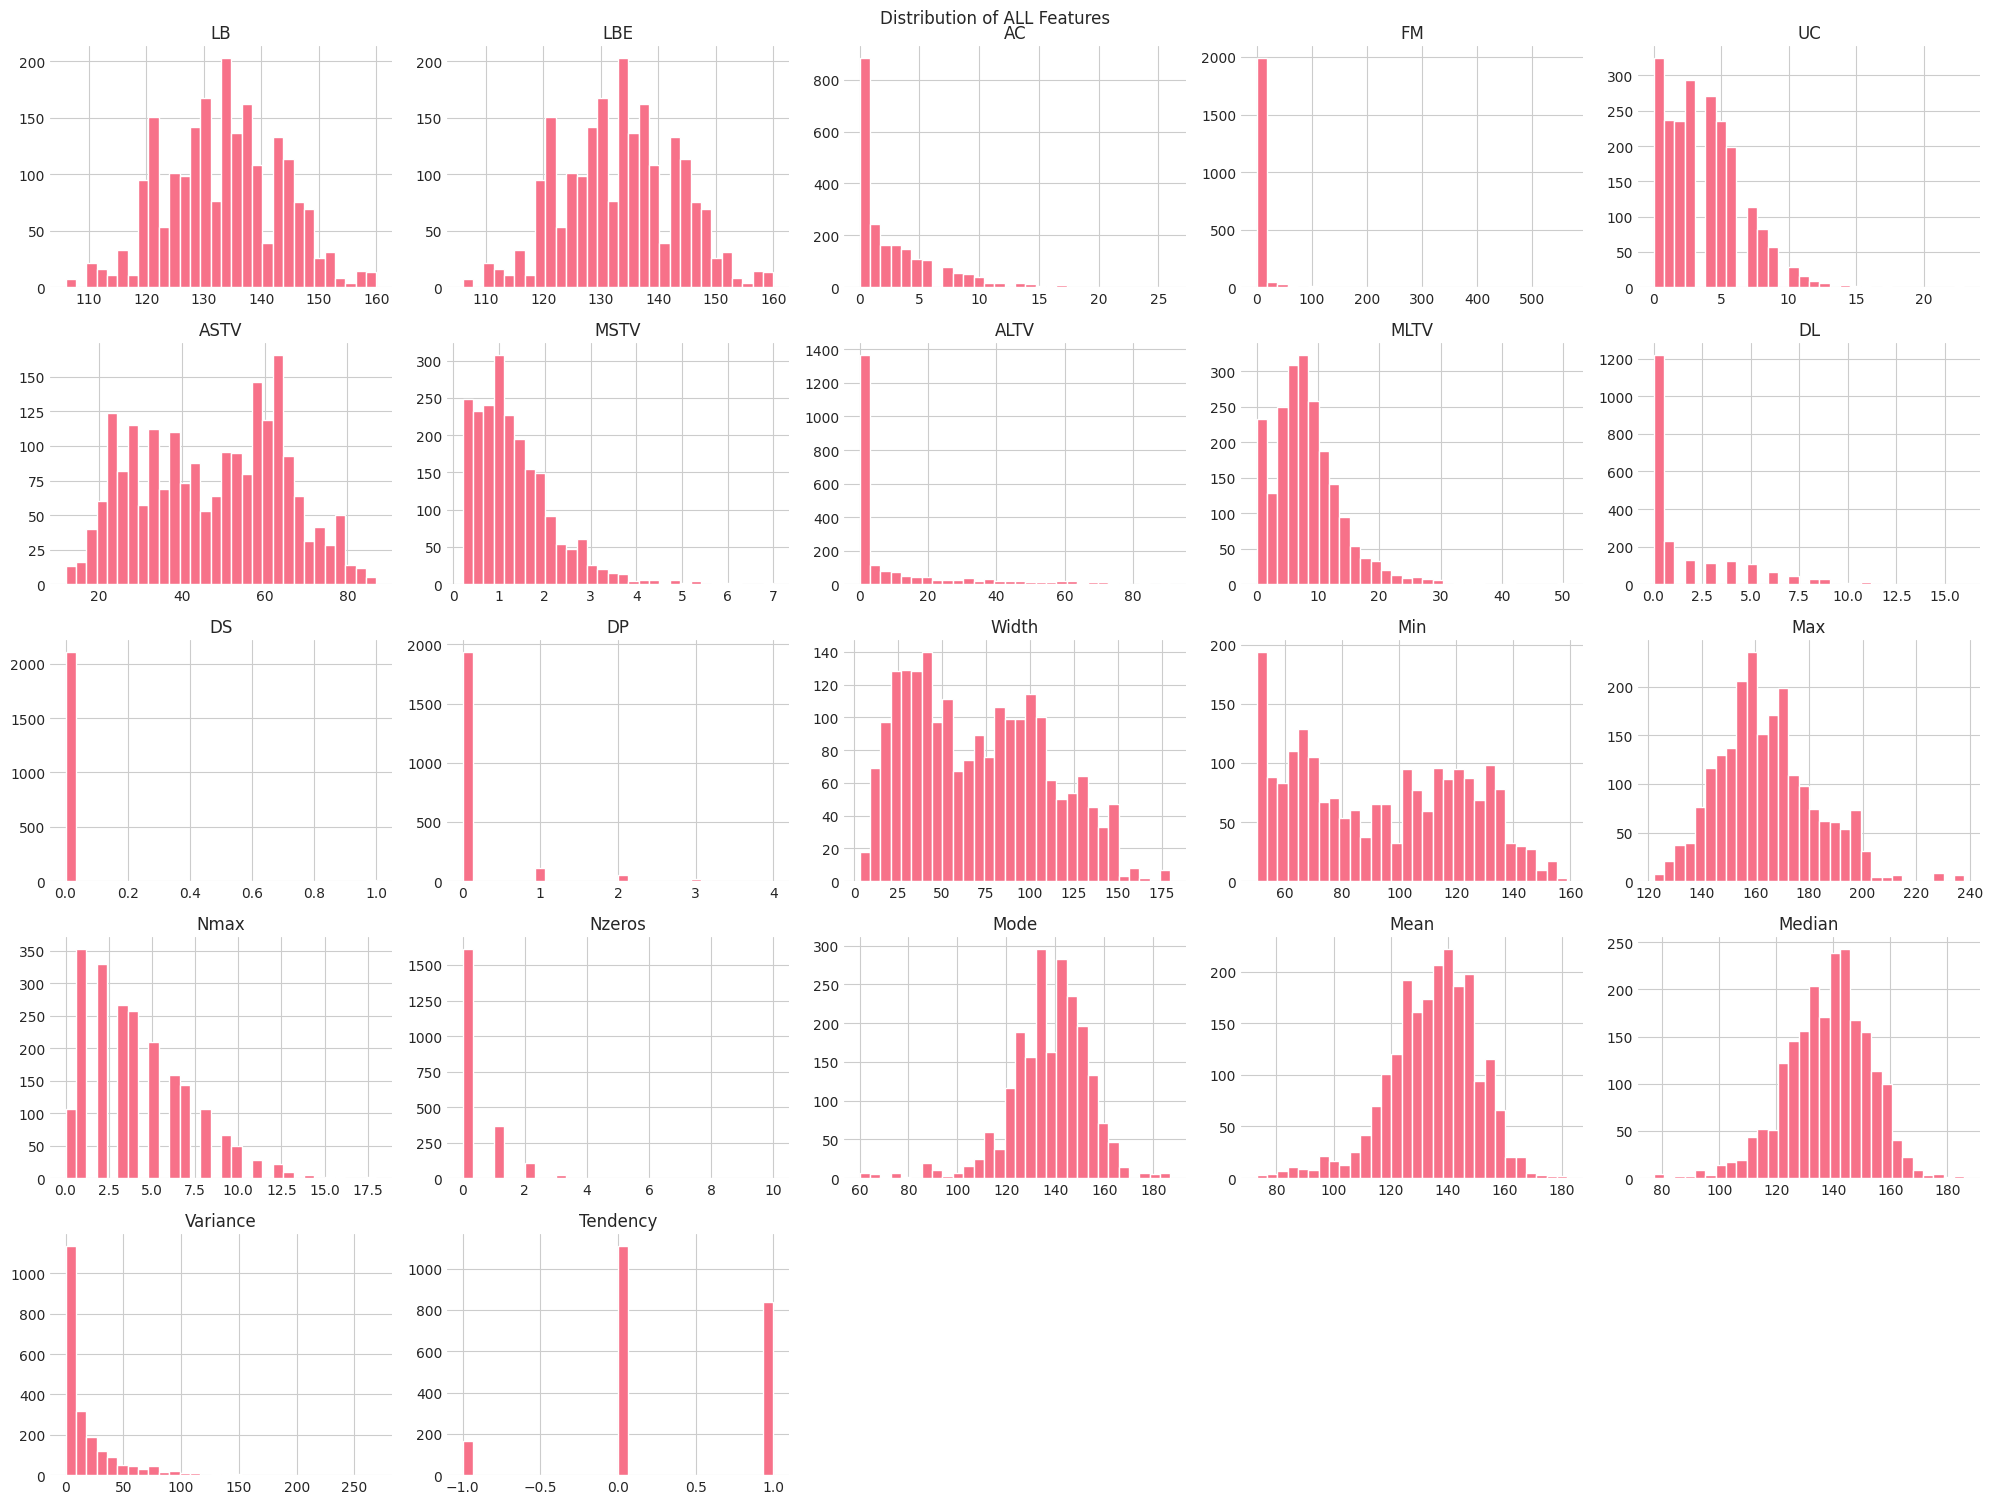

In [337]:
# Plot ALL features
all_features = ['LB','LBE','AC', 'FM', 'UC',
                'ASTV', 'MSTV', 'ALTV', 'MLTV',
                'DL', 'DS', 'DP',
                'Width', 'Min', 'Max',
                'Nmax', 'Nzeros',
                'Mode', 'Mean', 'Median', 'Variance', 'Tendency']
df[all_features].hist(figsize=(20, 15), bins=30)
plt.tight_layout()
plt.suptitle('Distribution of ALL Features', y=1.00)
plt.show()

# 2.1.2 Checking outliers

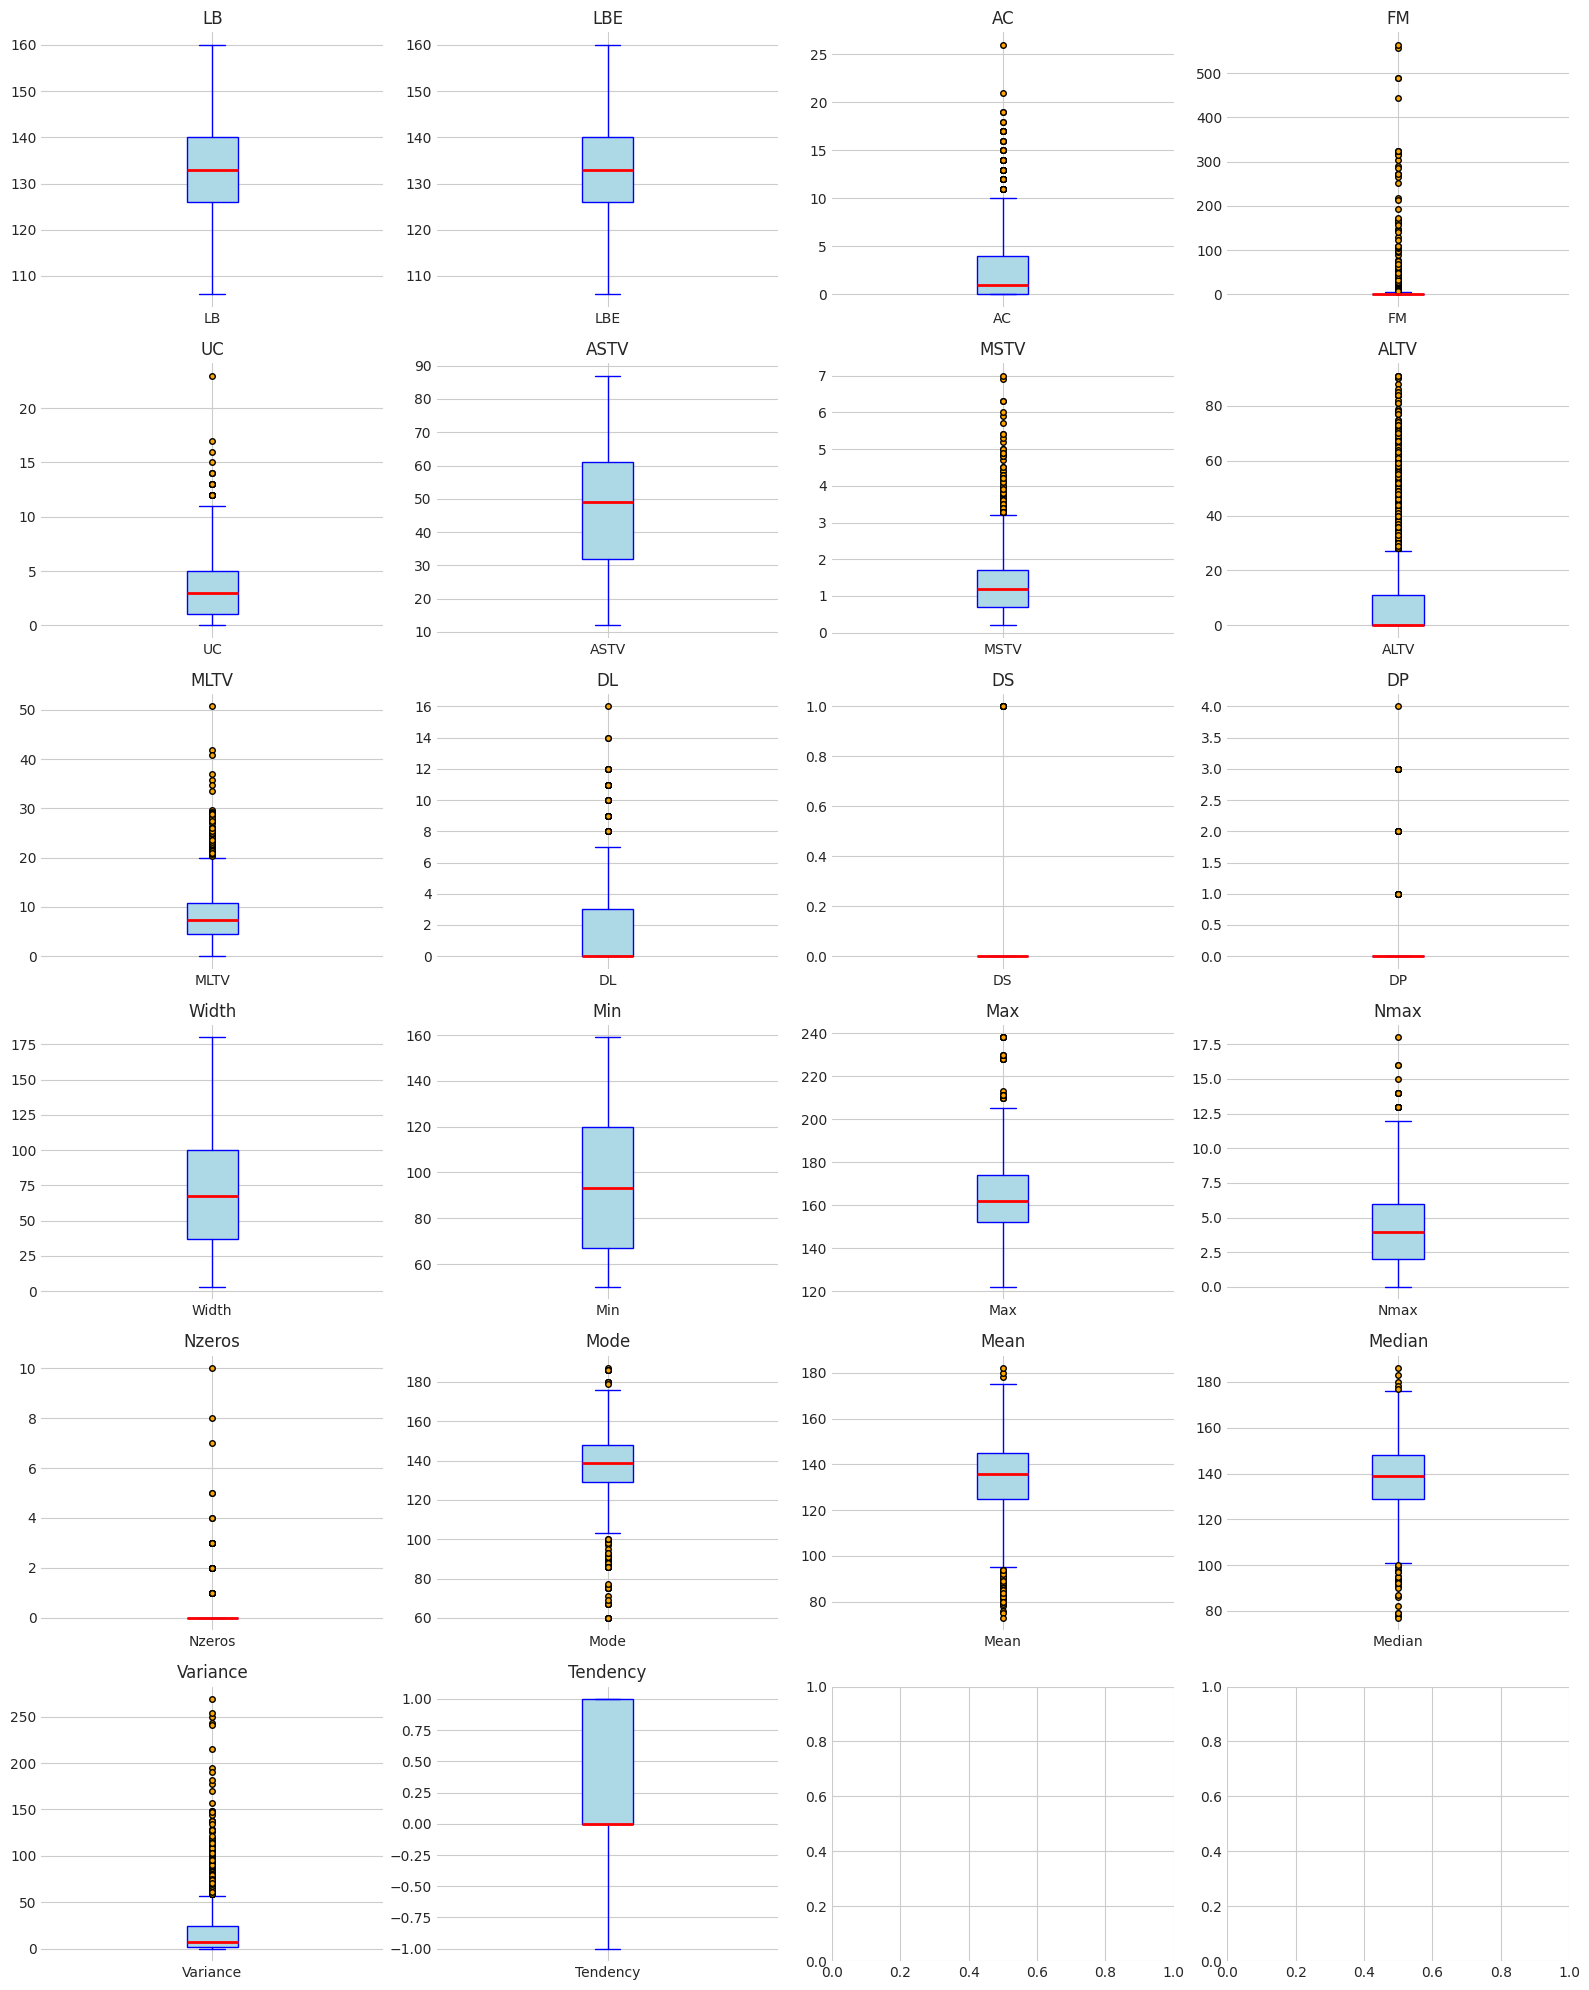

In [338]:
# Boxplot for ALL features
fig, axes = plt.subplots(6, 4, figsize=(16, 20))
axes = axes.ravel()

for i, col in enumerate(all_features):
    df.boxplot(
        column=col,
        ax=axes[i],
        patch_artist=True,   # <-- allow coloring
        boxprops=dict(facecolor="lightblue", color="blue"),
        whiskerprops=dict(color="blue"),
        capprops=dict(color="blue"),
        medianprops=dict(color="red", linewidth=2),
        flierprops=dict(markerfacecolor="orange", marker="o", markersize=4, linestyle="none")
    )
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

#2.1.3 Checking correlations (find duplicates)

Since we look for the dataset, LB and LBE looks similar and hence we check whether they are identical

In [339]:
print("Are LB and LBE identical?")
print((df['LB'] == df['LBE']).all())
print(f"\nCorrelation: {df['LB'].corr(df['LBE']):.6f}")

Are LB and LBE identical?
True

Correlation: 1.000000


NSP
1.0    1648
2.0     293
3.0     175
Name: count, dtype: int64


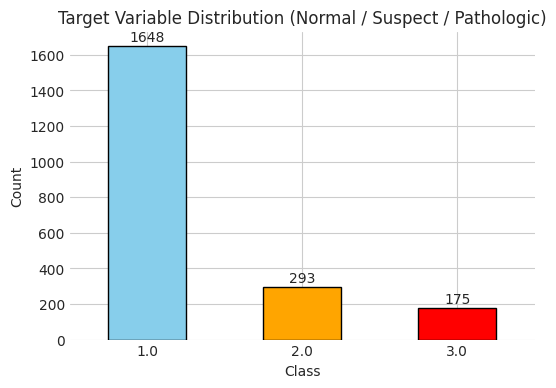

In [340]:
# Count the labels
label_counts = df['NSP'].value_counts()
print(label_counts)

# Plot bar chart
plt.figure(figsize=(6,4))
label_counts.plot(kind='bar', color=['skyblue','orange','red'], edgecolor='black')

plt.title("Target Variable Distribution (Normal / Suspect / Pathologic)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=0)

# Show counts on bars
for idx, val in enumerate(label_counts.values):
    plt.text(idx, val + 10, str(val), ha='center', va='bottom', fontsize=10)

plt.show()


# 2.1.4 Impossible values check

In [341]:
impossible_ranges = {
    # HEART RATE FEATURES (bpm = beats per minute)
    'LB': {
        'min': 50,     # Below 50 bpm = likely equipment error
        'max': 240,    # Above 240 bpm = physically impossible for fetus
        'reason': 'Baseline heart rate outside physiologically possible range'
    },
    'Min': {
        'min': 50,
        'max': 200,
        'reason': 'Minimum heart rate impossible'
    },
    'Max': {
        'min': 80,
        'max': 240,
        'reason': 'Maximum heart rate impossible'
    },
    'Mean': {
        'min': 50,
        'max': 200,
        'reason': 'Mean heart rate impossible'
    },
    'Median': {
        'min': 50,
        'max': 200,
        'reason': 'Median heart rate impossible'
    },

    # COUNT FEATURES (must be >= 0)
    'AC': {
        'min': 0,
        'max': 50,     # >50 accelerations in 20 min = unrealistic
        'reason': 'Accelerations count must be non-negative and realistic'
    },
    'FM': {
        'min': 0,
        'max': 100,    # Very generous upper limit
        'reason': 'Fetal movements count must be non-negative'
    },
    'UC': {
        'min': 0,
        'max': 30,     # >30 contractions = unrealistic
        'reason': 'Uterine contractions count must be non-negative'
    },
    'DL': {
        'min': 0,
        'max': 50,
        'reason': 'Light decelerations count must be non-negative'
    },
    'DS': {
        'min': 0,
        'max': 50,
        'reason': 'Severe decelerations count must be non-negative'
    },
    'DP': {
        'min': 0,
        'max': 20,
        'reason': 'Prolonged decelerations count must be non-negative'
    },
    'DR': {
        'min': 0,
        'max': 50,
        'reason': 'Repetitive decelerations must be non-negative'
    },

    # VARIABILITY FEATURES (percentage or ms)
    'ASTV': {
        'min': 0,
        'max': 200,    # Very generous - extreme variability possible in distress
        'reason': 'Abnormal short-term variability outside possible range'
    },
    'MSTV': {
        'min': 0,
        'max': 50,
        'reason': 'Mean short-term variability outside possible range'
    },
    'ALTV': {
        'min': 0,
        'max': 200,
        'reason': 'Abnormal long-term variability outside possible range'
    },
    'MLTV': {
        'min': 0,
        'max': 100,
        'reason': 'Mean long-term variability outside possible range'
    },

    # HISTOGRAM FEATURES
    'Width': {
        'min': 0,
        'max': 300,    # Width of heart rate distribution
        'reason': 'Histogram width outside possible range'
    },
    'Variance': {
        'min': 0,
        'max': 10000,  # Very generous - extreme variance possible
        'reason': 'Variance must be non-negative'
    },
    'Nmax': {
        'min': 0,
        'max': 50,
        'reason': 'Number of histogram peaks must be non-negative'
    },
    'Nzeros': {
        'min': 0,
        'max': 100,
        'reason': 'Number of zeros in histogram must be non-negative'
    },
    'Mode': {
        'min': 50,
        'max': 200,
        'reason': 'Mode of heart rate distribution impossible'
    }
}

print("SCANNING FOR IMPOSSIBLE VALUES")
print("="*70)

issues_found = []

for feature, limits in impossible_ranges.items():
    if feature not in df.columns:
        continue

    # Check for values outside range
    below_min = df[df[feature] < limits['min']]
    above_max = df[df[feature] > limits['max']]

    total_issues = len(below_min) + len(above_max)

    if total_issues > 0:
        issues_found.append({
            'Feature': feature,
            'Below_Min': len(below_min),
            'Above_Max': len(above_max),
            'Total_Issues': total_issues,
            'Percentage': f"{(total_issues/len(df)*100):.2f}%",
            'Min_Found': df[feature].min(),
            'Max_Found': df[feature].max(),
            'Expected_Range': f"[{limits['min']}, {limits['max']}]"
        })

        print(f"\n {feature}:")
        print(f"   Expected range: [{limits['min']}, {limits['max']}]")
        print(f"   Found range: [{df[feature].min():.2f}, {df[feature].max():.2f}]")
        print(f"   Issues: {total_issues} samples ({total_issues/len(df)*100:.2f}%)")
        if len(below_min) > 0:
            print(f"   - {len(below_min)} below minimum")
        if len(above_max) > 0:
            print(f"   - {len(above_max)} above maximum")

if not issues_found:
    print("\n No impossible values found! Data looks clean.")
else:
    print(f"\n Summary: Found impossible values in {len(issues_found)} features")



print("REMOVING IMPOSSIBLE VALUES")
print("="*70)

df_clean = df.copy()

for feature, limits in impossible_ranges.items():
    if feature not in df_clean.columns:
        continue

    before = len(df_clean)

    # Remove rows with impossible values
    df_clean = df_clean[
        (df_clean[feature] >= limits['min']) &
        (df_clean[feature] <= limits['max'])
    ]

    after = len(df_clean)
    removed = before - after

    if removed > 0:
        print(f"  {feature}: Removed {removed} rows")

SCANNING FOR IMPOSSIBLE VALUES

 FM:
   Expected range: [0, 100]
   Found range: [0.00, 564.00]
   Issues: 35 samples (1.65%)
   - 35 above maximum

 Summary: Found impossible values in 1 features
REMOVING IMPOSSIBLE VALUES
  FM: Removed 35 rows


# 3.1 Data Preprocessing


# 3.1.1 Drop perfect duplicates

In [342]:
# Drop LBE, keep LB
df = df.drop(columns=['LBE'])
print("Dropped LBE (duplicate of LB)")

Dropped LBE (duplicate of LB)


#3.1.2 Remove redundant variables

Our classification task is limited to determining fetal states as Normal, Suspect, or Pathologic, represented by the target variable NSP.

Other columns such as A, B, C, D, E (sleep/vigilance states) and AD, DE, LD, FS, SUSP (pattern descriptions) provide alternative labeling systems that describe the same underlying fetal condition.


Since these variables are redundant to our primary target, they were excluded to avoid noise and ensure the model focuses solely on NSP.

In [343]:
target = 'NSP'  # 1=Normal, 2=Suspect, 3=Pathologic

# Drop all other label columns
label_columns = ['A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP', 'CLASS']
df = df.drop(columns=label_columns)

In [344]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2116 entries, 1 to 2126
Data columns (total 25 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   b         2116 non-null   float64 
 1   e         2116 non-null   float64 
 2   LB        2116 non-null   float64 
 3   AC        2116 non-null   float64 
 4   FM        2116 non-null   float64 
 5   UC        2116 non-null   float64 
 6   ASTV      2116 non-null   float64 
 7   MSTV      2116 non-null   float64 
 8   ALTV      2116 non-null   float64 
 9   MLTV      2116 non-null   float64 
 10  DL        2116 non-null   float64 
 11  DS        2116 non-null   float64 
 12  DP        2116 non-null   float64 
 13  DR        2116 non-null   float64 
 14  Width     2116 non-null   float64 
 15  Min       2116 non-null   float64 
 16  Max       2116 non-null   float64 
 17  Nmax      2116 non-null   float64 
 18  Nzeros    2116 non-null   float64 
 19  Mode      2116 non-null   float64 
 20  Mean      211

# 4.1 Exploring the relationships


# 4.1.1 Correlation Heatmap Analysis

In [365]:
print(df['DR'].dtype)     # check type
print(df['DR'].nunique()) # see how many unique values
print(df['DR'].isna().sum()) # count missing values


float64
1
0


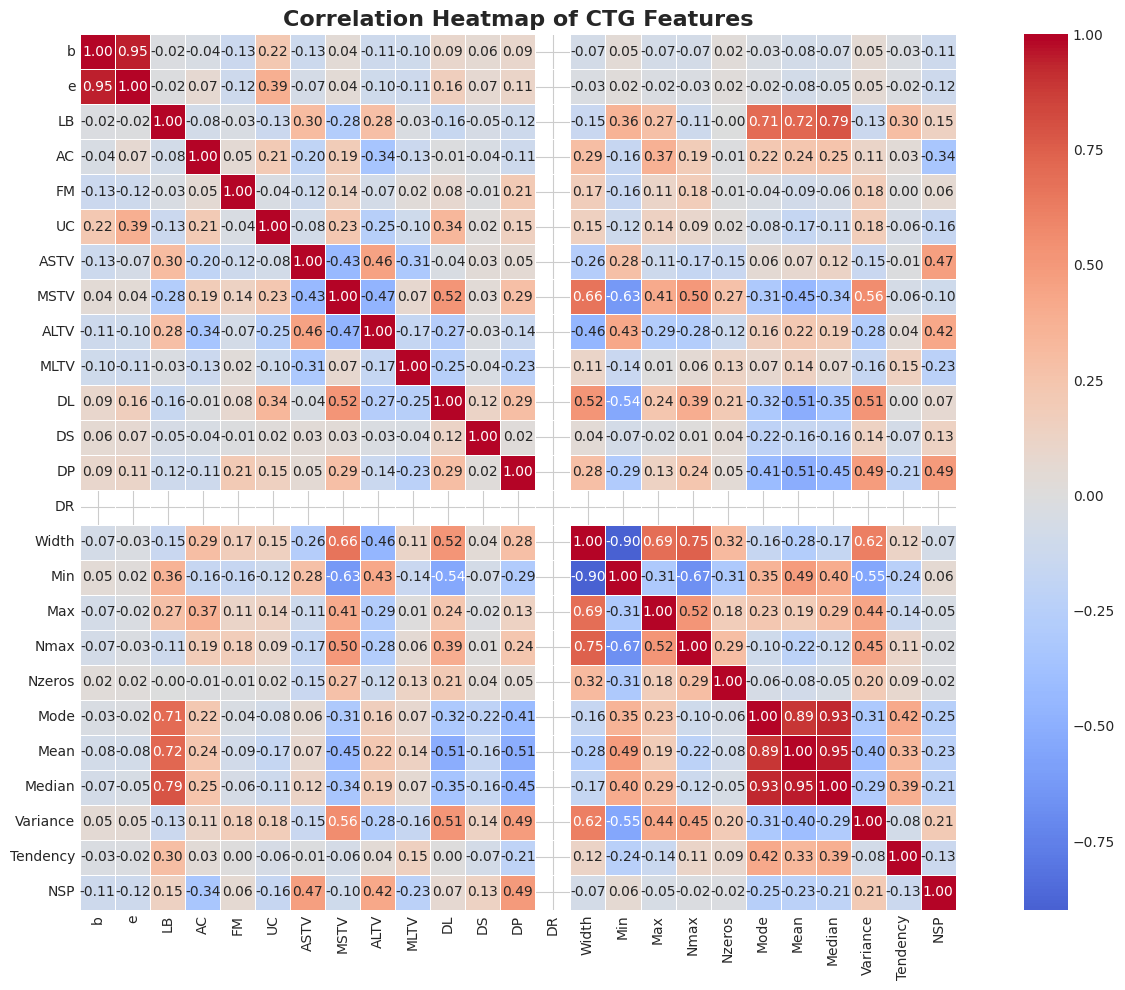

In [345]:
# Create correlation heatmap
plt.figure(figsize=(14, 10))
correlation_matrix = df.corr()

sns.heatmap(correlation_matrix,
            annot=True,  # Show correlation values
            fmt='.2f',   # 2 decimal places
            cmap='coolwarm',  # Red = positive, Blue = negative
            center=0,
            square=True,
            linewidths=0.5)

plt.title('Correlation Heatmap of CTG Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Based on the correlation heatmap, here are the key insights about the CTG features and their relationships with fetal health:

**1. Strongest Predictors of Fetal Distress (NSP Correlations)**

**High-Risk Indicators (Positive Correlations):**


*  DP (Prolonged Decelerations): +0.49 - The strongest predictor of pathology. When a baby's heart rate remains low for extended periods, it indicates prolonged oxygen deprivation requiring urgent intervention.
*  ASTV (Abnormal Short-Term Variability): +0.47 - Flat or chaotic moment-to-moment heart rate patterns signal that the baby is not responding normally to stimuli.
* ALTV (Abnormal Long-Term Variability): +0.42 - Abnormal patterns over longer time periods indicate sustained distress.


**Protective Indicators (Negative Correlations):**

As the feature increases, the label tends to shift towards the lower classes (Normal).

* AC (Accelerations): -0.34 - Frequent heart rate spikes indicate an active, well-oxygenated baby. More accelerations = lower risk.

* Histogram Statistics (Mode: -0.25, Mean: -0.23, Median: -0.21) -Higher (more central/normal) values of these statistics are associated with lower NSP codes (Normal). Stable, consistent heart rate distributions are associated with healthy outcomes.



**Accelerations and Uterine Contractions (AC-UC: +0.21):**

* Moderate positive correlation indicates healthy babies accelerate their heart rate during/after contractions
* In real-world terms: when the womb contracts and briefly stresses the baby, a healthy baby’s heart rate should accelerate (speed up for a moment) as an adaptive response.

**Width and Variability Features:**

* Width strongly correlates with Min (-0.90) and Max (0.69)
* Min = lowest fetal heart rate.
* Max = highest fetal heart rate.
* Width ↔ Min (r = -0.90) → If the minimum heart rate drops, the width grows
* Width ↔ Max (r = +0.69) → If the maximum heart rate rises, the width also grows.



---


**Normal babies: have narrower heart rate ranges → Width is smaller, Min/Max are within safe limits.**

**Suspect/Pathologic babies: often show very low dips (severe decelerations) or extreme highs (tachycardia) → this increases Width.**



---

3. Clinical Validation

Our findings confirm established medical knowledge:

* Babies with very low variability almost always ended up in the Pathologic group. Confirmed by strong ASTV (0.47) and ALTV (0.42) correlations


# 4.1.2  Histogram

Plot distribution of key features (LB, AC, FM, UC, ASTV, ALTV, DS, DP, DL).

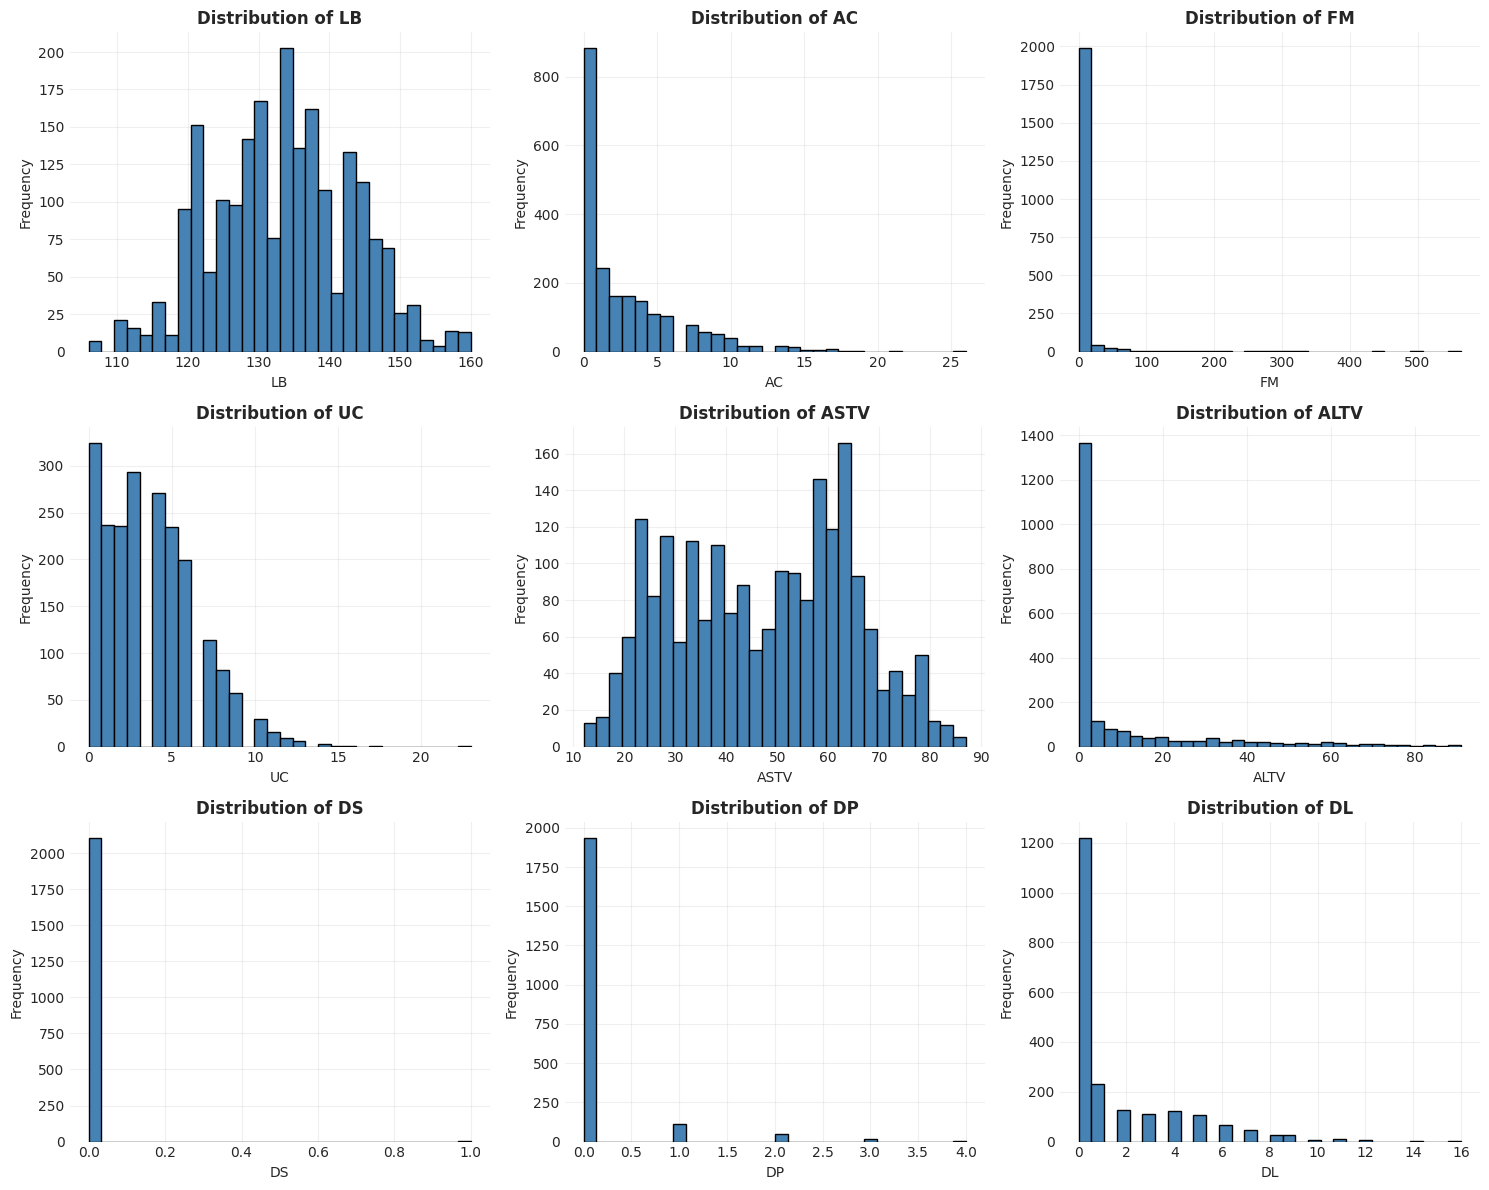

In [346]:
# Key features to plot
features = ['LB', 'AC', 'FM', 'UC', 'ASTV', 'ALTV', 'DS', 'DP', 'DL']

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, feature in enumerate(features):
    axes[idx].hist(df[feature], bins=30, color='steelblue', edgecolor='black')
    axes[idx].set_title(f'Distribution of {feature}', fontweight='bold')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

**Histogram Analysis: Feature Distributions**

1. Baseline Heart Rate (LB)


*   Distribution: Approximately normal (bell-shaped) centered around 130-140 bpm
*   Range: Mostly 110-160 bpm, which aligns with healthy fetal heart rate
* Clinical Insight: The symmetric distribution suggests most babies in the dataset had normal baseline heart rates. Few extreme values (bradycardia <110 or tachycardia >160).

2. Severe Decelerations (DS)

*   Distribution: Extremely right-skewed, ~2100 cases at 0
*   Pattern: Almost all cases have 0 severe decelerations
*   This is GOOD - severe decelerations should be rare in a general population

3. Abnormal Short-Term Variability (ASTV)
* Distribution: Bimodal with peaks around 20 and 60-70
* Pattern: Two distinct groups emerge
* Clinical Significance:
  * Lower peak (~20): Likely Normal cases with minimal abnormality
* Strong Predictor: This bimodal pattern suggests ASTV effectively separates healthy from distressed babies

4. Abnormal Long-Term Variability (ALTV)
* Distribution: Extremely right-skewed, massive spike at 0
* Clinical Insight: Most babies show normal long-term variability (good sign). When ALTV is elevated, it's a red flag.






Challenges for Modeling:
1. Sparse Features (Zero-Inflated):

FM, DS, DP, DL are mostly zeros
This makes them rare but important signals when non-zero
Models need to learn: "presence of these = high risk"

2. Skewed Distributions:

AC, DL, ALTV, UC all right-skewed
May benefit from log transformation or **scaling
Tree-based models (Random Forest, XGBoost) handle skewness well**

# 4.1.3 Boxplot

To confirm our hypotheses, we need boxplots comparing these distributions across Normal/Suspect/Pathologic groups.

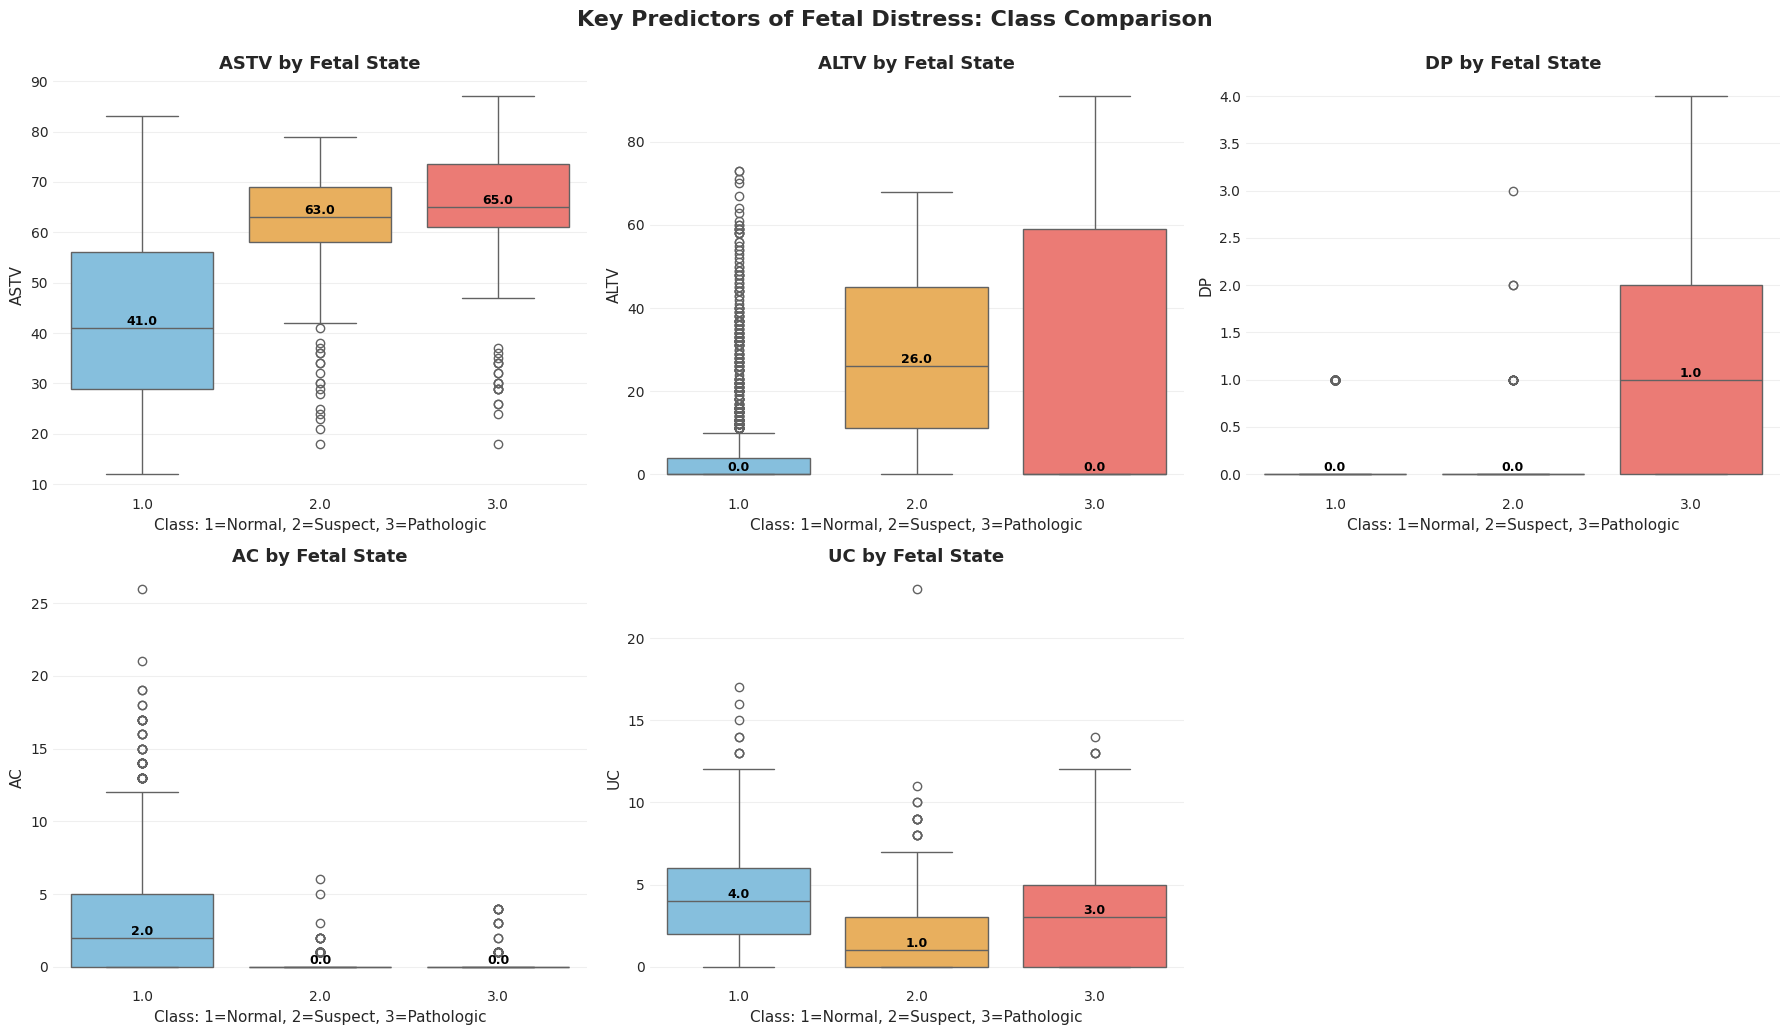

In [347]:
# Focus on 5 key features
top_features = ['ASTV', 'ALTV', 'DP', 'AC', 'UC']

# Create a 2x3 grid (6 spaces, 1 will stay empty)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

# Define consistent color palette
colors = ['#77C3EC', '#FFB347', '#FF6961']  # blue, orange, red

for idx, feature in enumerate(top_features):
    sns.boxplot(x='NSP', y=feature, data=df, ax=axes[idx], palette=colors)
    axes[idx].set_title(f'{feature} by Fetal State', fontweight='bold', fontsize=13)
    axes[idx].set_xlabel('Class: 1=Normal, 2=Suspect, 3=Pathologic', fontsize=11)
    axes[idx].set_ylabel(feature, fontsize=11)
    axes[idx].grid(axis='y', alpha=0.3)

    # Add median values
    medians = df.groupby('NSP')[feature].median()
    for i, median in enumerate(medians):
        axes[idx].text(i, median, f'{median:.1f}',
                      ha='center', va='bottom', fontweight='bold', fontsize=9, color='black')

# Hide the last empty subplot if features < 6
if len(top_features) < len(axes):
    for j in range(len(top_features), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Key Predictors of Fetal Distress: Class Comparison',
             fontsize=16, fontweight='bold', y=1.03)
plt.show()


1. ASTV (Abnormal Short-Term Variability)

Clear Progressive Pattern:


*   Normal (Class 1): Median = 41.0, IQR ~30-56
*   Suspect (Class 2): Median = 63.0, IQR ~59-69
*   Pathologic (Class 3): Median = 65.0, IQR ~61-74

**Clinical Insight:**

* Pathologic cases show consistently high ASTV (>60), indicating flat or erratic heart rate variability
* This confirms: Babies with abnormal variability end up in higher-risk groups

2. ALTV (Abnormal Long-Term Variability)

Dramatic Separation:
* Normal (Class 1): Median = 0.0, extremely compressed box (most values at 0)
* Suspect (Class 2): Median = 26.0, wide spread (IQR ~13-46)
* Pathologic (Class 3): Median = 0.0 BUT wide range extending to 90

**Clinical Insight:**
* Normal babies have virtually NO abnormal long-term variability (good sign)
* Suspect cases show moderate elevation - warning flag
* Pathologic shows bimodal pattern: some at 0, others very high (up to 90)
* Key finding: ALTV presence strongly indicates distress, but its absence doesn't guarantee normalcy in Pathologic cases

3. DP (Prolonged Decelerations)

Most Discriminative Feature:


*   Normal (Class 1): Median = 0.0, box completely flat (almost no cases have DP)
*   Suspect (Class 2): Median = 0.0, box flat with rare outliers (2-3 cases)
* Pathologic (Class 3): Median = 1.0, IQR 0-2, extends to 4

**Clinical Insight:**
* Extremely sparse in Normal/Suspect - prolonged decelerations are rare events
* Present in Pathologic cases - median of 1 means most pathologic babies experienced at least one prolonged deceleration
* This aligns perfectly with the correlation analysis (DP had +0.49 correlation with NSP)
* Critical clinical rule confirmed: Presence of even ONE prolonged deceleration is a major red flag

4.  AC (Accelerations)

Inverse Relationship (Protective Factor):



*  Normal (Class 1): Median = 2.0, IQR 0-5, many outliers up to 26
*  Suspect (Class 2): Median = 0.0, compressed box, rare high values
*  Pathologic (Class 3): Median = 0.0, extremely compressed, almost no accelerations

**Clinical Insight:**


*   Normal babies show MORE accelerations - indicating active, responsive, well-oxygenated fetuses
*   Pathologic babies show almost NONE - lack of accelerations = lack of reactivity = distress
* The high outliers in Normal class (reaching 26) represent very active, healthy babies
* This confirms the negative correlation (-0.34) we saw in the heatmap

5. UC (Uterine Contractions)
* Normal (Class 1): Median = 4.0, IQR ~2-6
* Suspect (Class 2): Median = 1.0, IQR ~0-3
* Pathologic (Class 3): Median = 3.0, IQR ~0-5

* Surprising Finding: Suspect cases show FEWER contractions

* The boxplot reveals an unexpected pattern - Suspect cases experienced the fewest contractions (median = 1), while Normal and Pathologic cases had similar contraction frequencies (medians of 4.0 and 3.0 respectively). This challenges the assumption that more contractions = more stress = worse outcomes.

* What this tells us clinically:
    * The weak correlation between UC and NSP (-0.16) now makes sense: fetal outcome depends on response quality, not stress quantity

Key Takeaway: UC provides the context (stress input), but the fetal response features (ASTV, ALTV, AC, DP) determine the outcome.



---



**Strongest Discriminators (in order):**

* DP (Prolonged Decelerations): Almost exclusive to Pathologic - binary indicator
* AC (Accelerations): Clear inverse relationship - presence = healthy, absence = distress
* ASTV: Progressive increase from Normal → Suspect → Pathologic
* ALTV: Normal cases near zero, elevated in Suspect/Pathologic
* UC (Uterine Contractions): Provides stress context but weak direct predictor - validates that fetal response quality matters more than stress quantity

# 5.1 Data Splitting

The purpose of splitting the dataset is to train the model on one subset (training set) and evaluate its performance on another subset (test set) that it hasn't seen during training.

In [348]:
X = df.drop(columns=['NSP']) #X contains all the features
y = df['NSP']                #Y contains the target variables

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
) #20% of the data goes to test set and to% of data goes to training set

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (1692, 24), Test: (424, 24)


In [349]:
X_train

,b,e,LB,AC,FM,UC,ASTV,MSTV,ALTV,MLTV,...,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
1311,52.0,1230.0,126.0,8.0,9.0,6.0,21.0,2.3,0.0,4.2,...,107.0,67.0,174.0,6.0,0.0,143.0,125.0,133.0,78.0,0.0
866,1214.0,1796.0,142.0,1.0,0.0,2.0,38.0,0.9,0.0,11.4,...,32.0,127.0,159.0,1.0,0.0,151.0,146.0,149.0,5.0,0.0
1781,680.0,1767.0,121.0,6.0,2.0,4.0,57.0,1.3,0.0,14.1,...,76.0,90.0,166.0,3.0,0.0,124.0,126.0,126.0,17.0,0.0
19,8.0,711.0,130.0,2.0,317.0,4.0,23.0,1.9,0.0,8.8,...,99.0,59.0,158.0,6.0,0.0,133.0,124.0,129.0,36.0,1.0
1292,174.0,565.0,115.0,0.0,0.0,3.0,15.0,2.2,0.0,6.8,...,55.0,84.0,139.0,4.0,0.0,119.0,111.0,115.0,19.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
952,2708.0,3540.0,142.0,0.0,0.0,2.0,31.0,1.2,0.0,24.1,...,67.0,94.0,161.0,2.0,0.0,151.0,145.0,148.0,10.0,1.0
1253,1893.0,2396.0,112.0,0.0,0.0,2.0,23.0,1.3,11.0,13.0,...,40.0,104.0,144.0,1.0,0.0,112.0,113.0,114.0,2.0,-1.0
1452,145.0,702.0,148.0,0.0,0.0,3.0,49.0,0.6,1.0,9.6,...,21.0,143.0,164.0,0.0,0.0,155.0,154.0,156.0,0.0,0.0
1793,1922.0,2894.0,121.0,0.0,1.0,3.0,67.0,2.1,0.0,0.0,...,102.0,55.0,157.0,4.0,1.0,67.0,81.0,87.0,89.0,-1.0


# 5.2 Feature Engineering

Adding new features based on the insights from heatmap,histogram and boxplot

In [350]:
print("Creating features...")

# Make copies to avoid modifying originals
X_train_eng = X_train.copy()
X_test_eng = X_test.copy()

# 1. Interaction Features
X_train_eng['AC_per_UC'] = X_train_eng['AC'] / (X_train_eng['UC'] + 1)
X_test_eng['AC_per_UC'] = X_test_eng['AC'] / (X_test_eng['UC'] + 1)

X_train_eng['ASTV_ALTV_ratio'] = X_train_eng['ASTV'] / (X_train_eng['ALTV'] + 1)
X_test_eng['ASTV_ALTV_ratio'] = X_test_eng['ASTV'] / (X_test_eng['ALTV'] + 1)

X_train_eng['total_abnormal_var'] = X_train_eng['ASTV'] + X_train_eng['ALTV']
X_test_eng['total_abnormal_var'] = X_test_eng['ASTV'] + X_test_eng['ALTV']

# 2. Deceleration Severity
X_train_eng['decel_severity'] = (X_train_eng['DP'] * 3 +
                                  X_train_eng['DS'] * 2 +
                                  X_train_eng['DL'] * 1)
X_test_eng['decel_severity'] = (X_test_eng['DP'] * 3 +
                                 X_test_eng['DS'] * 2 +
                                 X_test_eng['DL'] * 1)

X_train_eng['total_decels'] = X_train_eng['DP'] + X_train_eng['DS'] + X_train_eng['DL']
X_test_eng['total_decels'] = X_test_eng['DP'] + X_test_eng['DS'] + X_test_eng['DL']

# 3. Binary flags for rare events
X_train_eng['has_severe_decel'] = (X_train_eng['DS'] > 0).astype(int)
X_test_eng['has_severe_decel'] = (X_test_eng['DS'] > 0).astype(int)

X_train_eng['has_prolonged_decel'] = (X_train_eng['DP'] > 0).astype(int)
X_test_eng['has_prolonged_decel'] = (X_test_eng['DP'] > 0).astype(int)

X_train_eng['has_movement'] = (X_train_eng['FM'] > 0).astype(int)
X_test_eng['has_movement'] = (X_test_eng['FM'] > 0).astype(int)

# 4. Heart rate range
X_train_eng['heart_rate_range'] = X_train_eng['Max'] - X_train_eng['Min']
X_test_eng['heart_rate_range'] = X_test_eng['Max'] - X_test_eng['Min']



Creating features...


1. AC_per_UC (Accelerations per Contraction)

* Medical meaning: How many times does the baby's heart speed up during each contraction?

Why better than using AC alone?
* Raw AC count doesn't account for contraction frequency
* A baby with 10 accelerations and 5 contractions (AC_per_UC = 2.0) is healthier than one with 10 accelerations but 20 contractions (AC_per_UC = 0.5)


2. ASTV_ALTV_ratio

Why useful?

* ASTV = abnormal short-term variability (% of time short-term variability is abnormal)

* ALTV = abnormal long-term variability

* Ratio highlights how much short-term abnormality dominates over long-term abnormality.

* Insight: High ratio = sudden, erratic instability → riskier


3. total_abnormal_var

•	Medical meaning: Overall “burden” of abnormal variability.

•	Clinical insight:

  * High total abnormal variability = baby’s heart is unstable across both short & long term → often linked to distress .
  * In practice, obstetricians look at both short- and long-term variability together, so this matches clinical reasoning.



4. decel_severity
* Not all decelerations are equal.
  * DL = light decel (small dips, not too serious)
  * DS = severe decel (deep, dangerous)
  * DP = prolonged decel (stays low too long, very dangerous)
  * Doctors don’t treat all decelerations equally — by weighting them, we try to mimic their thinking.

* Insight: Higher score = higher risk of Pathologic.

5. Binary Flags (has_severe_decel, has_prolonged_decel, has_movement)

* Medical meaning: Did this rare but critical event happen at all? (Yes/No).

Clinical insight:

* Doctors treat presence of any severe/prolonged decel as a red flag .

* Doesn’t matter if it happened once or twice → the fact it occurred is concerning

False negative prevention: The presence of any severe/prolonged decel is clinically alarming, regardless of count.

* Similarly, fetal movement (has_movement) is reassuring → absence could mean reduced responsiveness.

In [351]:
print(f"\nOriginal features: {X_train.shape[1]}")
print(f"Engineered features: {X_train_eng.shape[1]}")
print(f"Features added: {X_train_eng.shape[1] - X_train.shape[1]}")


Original features: 24
Engineered features: 33
Features added: 9


# 6.1 Model training and evaluation


In medical classification tasks, especially those involving fetal health, the priority is sensitivity (recall) for high-risk cases. Missing too many Pathologic cases could result in severe consequences for both mother and child.

**Therefore, our team set a minimum recall threshold of 85% for the Pathologic class.**


# 6.1.1 Logistic Regression


Logistic Regression was chosen as a baseline model because it is simple, interpretable, and effective for multi-class classification problems like ours.

In [352]:
# Initialize storage dictionary
all_model_results = {}

In [353]:
print("="*70)
print("LOGISTIC REGRESSION")
print("="*70)

# Logistic Regression NEEDS scaling (distance-based model)
print("\nScaling features for Logistic Regression...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_eng)
X_test_scaled = scaler.transform(X_test_eng)
print("Scaling complete")

# Train Logistic Regression with class weights
print("\nTraining Logistic Regression...")
lr_model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    class_weight='balanced',
    max_iter=1000,
    random_state=RANDOM_STATE
)
lr_model.fit(X_train_scaled, y_train)
print("Training complete!")

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)

# Evaluation
print("\n" + "="*70)
print("LOGISTIC REGRESSION RESULTS")
print("="*70)
bal_acc_lr = balanced_accuracy_score(y_test, y_pred_lr)
macro_f1_lr = f1_score(y_test, y_pred_lr, average='macro')
print(f"\nBalanced Accuracy: {bal_acc_lr:.4f}")
print(f"Macro F1-Score:    {macro_f1_lr:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr,
                          target_names=['Normal', 'Suspect', 'Pathologic']))

print("\nConfusion Matrix:")
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(cm_lr)
print("(Rows = Actual, Columns = Predicted)")

# False negative analysis
pathologic_total_lr = (y_test == 3).sum()
pathologic_correct_lr = cm_lr[2, 2]
pathologic_fn_lr = cm_lr[2, 0] + cm_lr[2, 1]
pathologic_recall_lr = pathologic_correct_lr / pathologic_total_lr if pathologic_total_lr > 0 else 0

print("\nMedical Safety Check:")
print(f"Pathologic cases: {pathologic_total_lr}")
print(f"Correctly identified: {pathologic_correct_lr} ({pathologic_recall_lr*100:.1f}%)")
print(f"Missed (FN): {pathologic_fn_lr} ({(1-pathologic_recall_lr)*100:.1f}%)")
print(f"  - Predicted as Normal: {cm_lr[2, 0]}")
print(f"  - Predicted as Suspect: {cm_lr[2, 1]}")

if pathologic_recall_lr < 0.85:
    print("\nWARNING: Pathologic recall < 85%")
else:
    print("\nGood: Catching most critical cases")

# Feature coefficients (top positive/negative for each class)
print("\n" + "="*70)
print("TOP FEATURES (by coefficient magnitude)")
print("="*70)
coef_df = pd.DataFrame(
    lr_model.coef_.T,
    columns=['Normal_coef', 'Suspect_coef', 'Pathologic_coef'],
    index=X_train_eng.columns
)
coef_df['abs_pathologic'] = coef_df['Pathologic_coef'].abs()
print("\nTop 10 features for Pathologic prediction:")
print(coef_df.sort_values('abs_pathologic', ascending=False).head(10)[['Pathologic_coef']])

all_model_results['Logistic Regression'] = {
    'bal_acc': bal_acc_lr,
    'macro_f1': macro_f1_lr,
    'pathologic_recall': pathologic_recall_lr,
    'normal_recall': cm_lr[0, 0] / (y_test == 1).sum() if (y_test == 1).sum() > 0 else 0,
    'suspect_recall': cm_lr[1, 1] / (y_test == 2).sum() if (y_test == 2).sum() > 0 else 0,
    'confusion_matrix': cm_lr
}


LOGISTIC REGRESSION

Scaling features for Logistic Regression...
Scaling complete

Training Logistic Regression...
Training complete!

LOGISTIC REGRESSION RESULTS

Balanced Accuracy: 0.8263
Macro F1-Score:    0.7834

Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.89      0.93       330
     Suspect       0.56      0.81      0.67        59
  Pathologic       0.73      0.77      0.75        35

    accuracy                           0.87       424
   macro avg       0.76      0.83      0.78       424
weighted avg       0.90      0.87      0.88       424


Confusion Matrix:
[[295  30   5]
 [  6  48   5]
 [  1   7  27]]
(Rows = Actual, Columns = Predicted)

Medical Safety Check:
Pathologic cases: 35
Correctly identified: 27 (77.1%)
Missed (FN): 8 (22.9%)
  - Predicted as Normal: 1
  - Predicted as Suspect: 7


TOP FEATURES (by coefficient magnitude)

Top 10 features for Pathologic prediction:
                    Pathologic_coef


Competition Metrics:
  Balanced Accuracy: 0.8263
  Macro F1-Score:    0.7834

Per-Class Performance:
  Normal       - Precision: 0.977, Recall: 0.894, F1: 0.934
  Suspect      - Precision: 0.565, Recall: 0.814, F1: 0.667
  Pathologic   - Precision: 0.730, Recall: 0.771, F1: 0.750


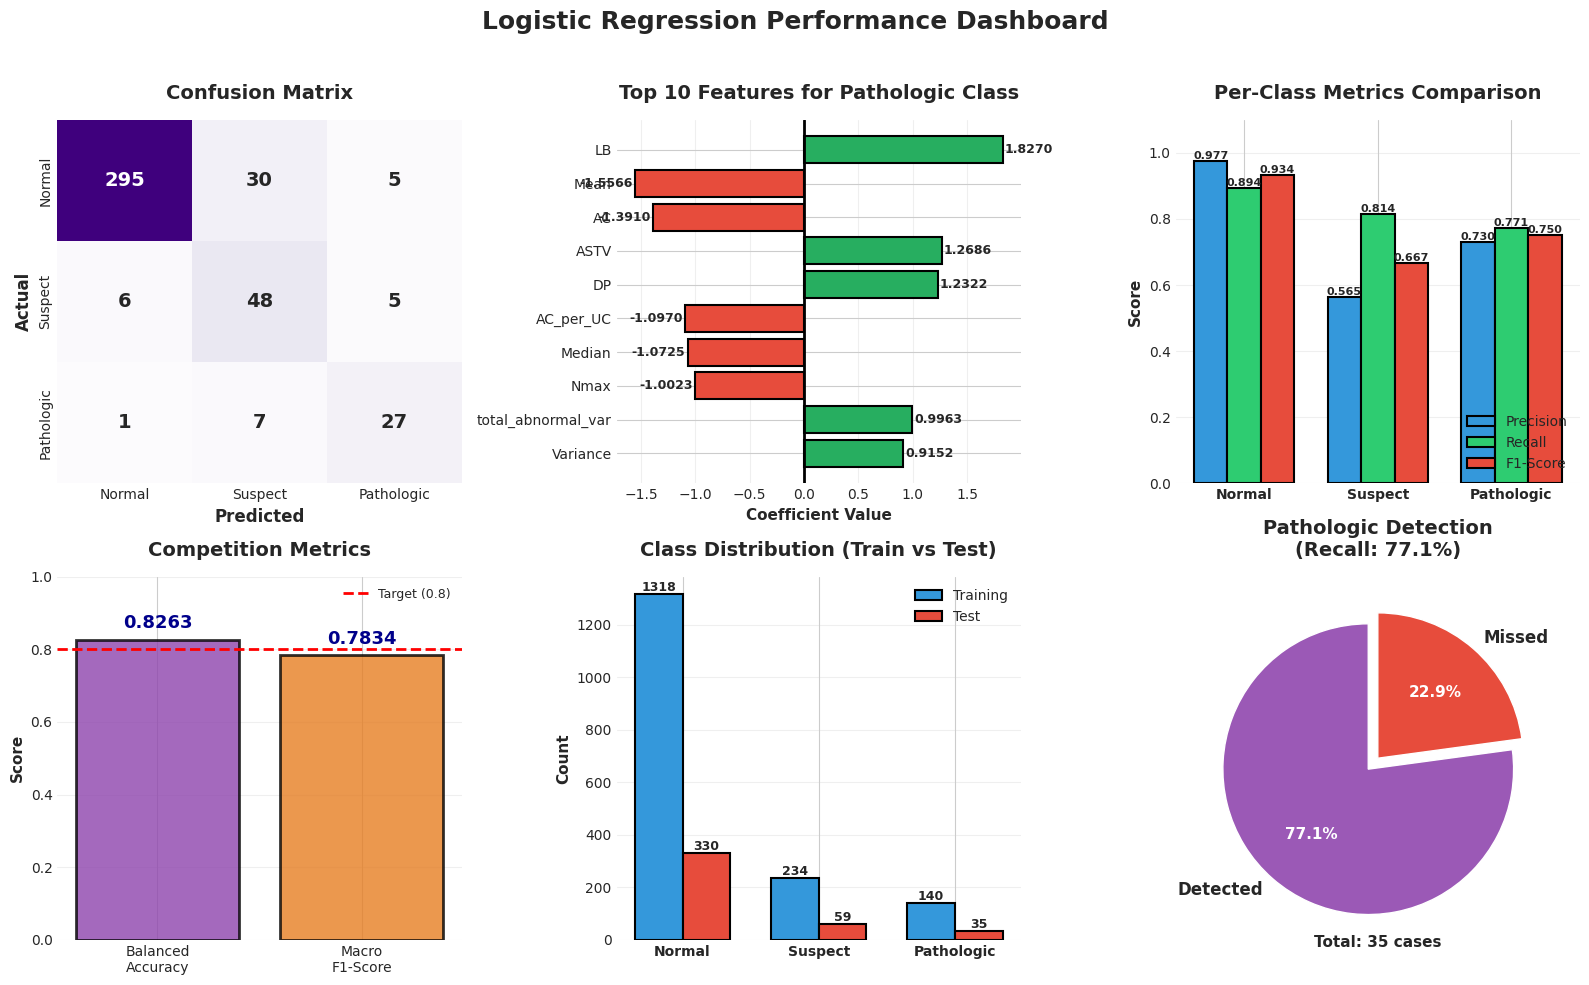

In [354]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_eng)
X_test_scaled = scaler.transform(X_test_eng)

# Train model
lr_model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    class_weight='balanced',
    max_iter=1000,
    random_state=RANDOM_STATE
)

lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

# Calculate metrics
bal_acc_lr = balanced_accuracy_score(y_test, y_pred_lr)
macro_f1_lr = f1_score(y_test, y_pred_lr, average='macro')
cm_lr = confusion_matrix(y_test, y_pred_lr)

# Print results
print("Competition Metrics:")
print(f"  Balanced Accuracy: {bal_acc_lr:.4f}")
print(f"  Macro F1-Score:    {macro_f1_lr:.4f}")

print("\nPer-Class Performance:")
report = classification_report(y_test, y_pred_lr,
                               target_names=['Normal', 'Suspect', 'Pathologic'],
                               output_dict=True)
for cls in ['Normal', 'Suspect', 'Pathologic']:
    print(f"  {cls:12s} - Precision: {report[cls]['precision']:.3f}, "
          f"Recall: {report[cls]['recall']:.3f}, F1: {report[cls]['f1-score']:.3f}")

# Visualization
fig = plt.figure(figsize=(16, 10))
sns.set_style("whitegrid")

# 1. Confusion Matrix
ax1 = plt.subplot(2, 3, 1)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Purples', cbar=False,
            xticklabels=['Normal', 'Suspect', 'Pathologic'],
            yticklabels=['Normal', 'Suspect', 'Pathologic'],
            ax=ax1, annot_kws={'size': 14, 'weight': 'bold'})
ax1.set_xlabel('Predicted', fontweight='bold', fontsize=12)
ax1.set_ylabel('Actual', fontweight='bold', fontsize=12)
ax1.set_title('Confusion Matrix', fontweight='bold', fontsize=14, pad=15)

# 2. Top 10 Features (by coefficient magnitude for Pathologic)
ax2 = plt.subplot(2, 3, 2)
coef_df = pd.DataFrame(
    lr_model.coef_.T,
    columns=['Normal_coef', 'Suspect_coef', 'Pathologic_coef'],
    index=X_train_eng.columns
)
coef_df['abs_pathologic'] = coef_df['Pathologic_coef'].abs()
top_features = coef_df.sort_values('abs_pathologic', ascending=False).head(10)

colors = ['#e74c3c' if x < 0 else '#27ae60' for x in top_features['Pathologic_coef']]
bars = ax2.barh(range(len(top_features)),
                top_features['Pathologic_coef'].values,
                color=colors, edgecolor='black', linewidth=1.5)
ax2.set_yticks(range(len(top_features)))
ax2.set_yticklabels(top_features.index, fontsize=10)
ax2.set_xlabel('Coefficient Value', fontweight='bold', fontsize=11)
ax2.set_title('Top 10 Features for Pathologic Class', fontweight='bold', fontsize=14, pad=15)
ax2.invert_yaxis()
ax2.axvline(x=0, color='black', linewidth=2)
ax2.grid(axis='x', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, top_features['Pathologic_coef'].values)):
    x_pos = val + (0.02 if val > 0 else -0.02)
    ha = 'left' if val > 0 else 'right'
    ax2.text(x_pos, bar.get_y() + bar.get_height()/2,
             f'{val:.4f}', va='center', ha=ha, fontsize=9, fontweight='bold')

# 3. Per-Class Metrics
ax3 = plt.subplot(2, 3, 3)
classes = ['Normal', 'Suspect', 'Pathologic']
metrics_data = {
    'Precision': [report[cls]['precision'] for cls in classes],
    'Recall': [report[cls]['recall'] for cls in classes],
    'F1-Score': [report[cls]['f1-score'] for cls in classes]
}

x = np.arange(len(classes))
width = 0.25

bars1 = ax3.bar(x - width, metrics_data['Precision'], width,
                label='Precision', color='#3498db', edgecolor='black', linewidth=1.5)
bars2 = ax3.bar(x, metrics_data['Recall'], width,
                label='Recall', color='#2ecc71', edgecolor='black', linewidth=1.5)
bars3 = ax3.bar(x + width, metrics_data['F1-Score'], width,
                label='F1-Score', color='#e74c3c', edgecolor='black', linewidth=1.5)

ax3.set_ylabel('Score', fontweight='bold', fontsize=11)
ax3.set_title('Per-Class Metrics Comparison', fontweight='bold', fontsize=14, pad=15)
ax3.set_xticks(x)
ax3.set_xticklabels(classes, fontsize=10, fontweight='bold')
ax3.legend(fontsize=10, loc='lower right')
ax3.set_ylim(0, 1.1)
ax3.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom',
                fontsize=8, fontweight='bold')

# 4. Competition Metrics
ax4 = plt.subplot(2, 3, 4)
metrics = ['Balanced\nAccuracy', 'Macro\nF1-Score']
scores = [bal_acc_lr, macro_f1_lr]
colors_gauge = ['#8e44ad', '#e67e22']

bars = ax4.bar(metrics, scores, color=colors_gauge,
               edgecolor='black', linewidth=2, alpha=0.8)
ax4.set_ylim(0, 1)
ax4.set_ylabel('Score', fontweight='bold', fontsize=11)
ax4.set_title('Competition Metrics', fontweight='bold', fontsize=14, pad=15)
ax4.axhline(y=0.8, color='red', linestyle='--', linewidth=2, label='Target (0.8)')
ax4.legend(fontsize=9)
ax4.grid(axis='y', alpha=0.3)

for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{score:.4f}', ha='center', va='bottom',
            fontsize=13, fontweight='bold', color='darkblue')

# 5. Class Distribution
ax5 = plt.subplot(2, 3, 5)
train_dist = y_train.value_counts().sort_index().values
test_dist = y_test.value_counts().sort_index().values

x = np.arange(len(classes))
width = 0.35

bars1 = ax5.bar(x - width/2, train_dist, width,
                label='Training', color='#3498db', edgecolor='black', linewidth=1.5)
bars2 = ax5.bar(x + width/2, test_dist, width,
                label='Test', color='#e74c3c', edgecolor='black', linewidth=1.5)

ax5.set_ylabel('Count', fontweight='bold', fontsize=11)
ax5.set_title('Class Distribution (Train vs Test)', fontweight='bold', fontsize=14, pad=15)
ax5.set_xticks(x)
ax5.set_xticklabels(classes, fontsize=10, fontweight='bold')
ax5.legend(fontsize=10)
ax5.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom',
                fontsize=9, fontweight='bold')

# 6. Pathologic Detection
ax6 = plt.subplot(2, 3, 6)
pathologic_recall = report['Pathologic']['recall']
pathologic_total = int(report['Pathologic']['support'])
pathologic_correct = int(pathologic_recall * pathologic_total)
pathologic_missed = pathologic_total - pathologic_correct

sizes = [pathologic_correct, pathologic_missed]
colors_pie = ['#9b59b6', '#e74c3c']
explode = (0.1, 0)

wedges, texts, autotexts = ax6.pie(sizes, explode=explode, labels=['Detected', 'Missed'],
                                     colors=colors_pie, autopct='%1.1f%%',
                                     startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})

ax6.set_title(f'Pathologic Detection\n(Recall: {pathologic_recall:.1%})',
              fontweight='bold', fontsize=14, pad=15)

plt.setp(autotexts, size=11, weight='bold', color='white')
ax6.text(0, -1.3, f'Total: {pathologic_total} cases',
         ha='center', fontsize=11, fontweight='bold')

# Overall title
fig.suptitle('Logistic Regression Performance Dashboard',
             fontsize=18, fontweight='bold', y=0.98)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('logistic_regression_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

Performance Overview:
* The model achieved a balanced accuracy of 82.6% and a macro F1-score of 0.78
* Normal class: Very strong performance (Precision: 0.98, Recall: 0.89).
* Suspect class: Good recall (0.81) but low precision (0.56), meaning many non-Suspect cases were misclassified as Suspect.
* Pathologic class: Reasonable precision (0.73) and recall (0.77). However, recall**is below the 85% medical safety threshold, meaning some high-risk cases were missed.**

**Medical Safety Check:**
* Confusion mostly between Suspect vs Normal and Suspect vs Pathologic (which is expected since Suspect is an “in-between” category
* False negatives in Pathologic = 8 cases (22.9%), mostly labeled as Suspect. This is a medical concern, as missed Pathologic cases could delay critical interventions.


Feature Insights (via Coefficients):
* Positive coefficients (e.g., LB = +1.83, ASTV = +1.27, DP = +1.23) increase the likelihood of Pathologic.
* Negative coefficients (e.g., Mean = -1.56, AC = -1.39, AC_per_UC = -1.09) reduce the odds of Pathologic.

* This gives useful interpretability but still cannot capture the complex, non-linear CTG patterns.

**Conclusion**
* Logistic Regression is a solid baseline with interpretability benefits.
* However, due to false negatives in Pathologic cases, it is not reliable enough for medical safety.

Hence we decide to explore Decision Tree models to capture non-linear relationships and improve high-risk case detection.


# 6.1.2 Decision Tree Model

In [355]:
print("\n" + "="*70)
print("DECISION TREE")
print("="*70)

# Decision Tree doesn't need scaling
print("\nTraining Decision Tree...")
dt_model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=RANDOM_STATE
)
dt_model.fit(X_train_eng, y_train)
print("Training complete!")

# Predictions
y_pred_dt = dt_model.predict(X_test_eng)

# Evaluation
print("\n" + "="*70)
print("DECISION TREE RESULTS")
print("="*70)
bal_acc_dt = balanced_accuracy_score(y_test, y_pred_dt)
macro_f1_dt = f1_score(y_test, y_pred_dt, average='macro')
print(f"\nBalanced Accuracy: {bal_acc_dt:.4f}")
print(f"Macro F1-Score:    {macro_f1_dt:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt,
                          target_names=['Normal', 'Suspect', 'Pathologic']))

print("\nConfusion Matrix:")
cm_dt = confusion_matrix(y_test, y_pred_dt)
print(cm_dt)
print("(Rows = Actual, Columns = Predicted)")

# False negative analysis
pathologic_total_dt = (y_test == 3).sum()
pathologic_correct_dt = cm_dt[2, 2]
pathologic_fn_dt = cm_dt[2, 0] + cm_dt[2, 1]
pathologic_recall_dt = pathologic_correct_dt / pathologic_total_dt if pathologic_total_dt > 0 else 0

print("\nMedical Safety Check:")
print(f"Pathologic cases: {pathologic_total_dt}")
print(f"Correctly identified: {pathologic_correct_dt} ({pathologic_recall_dt*100:.1f}%)")
print(f"Missed (FN): {pathologic_fn_dt} ({(1-pathologic_recall_dt)*100:.1f}%)")
print(f"  - Predicted as Normal: {cm_dt[2, 0]}")
print(f"  - Predicted as Suspect: {cm_dt[2, 1]}")

if pathologic_recall_dt < 0.85:
    print("WARNING: Pathologic recall < 85%")
else:
    print("Good: Catching most critical cases")

# Feature importance
print("\n" + "="*70)
print("FEATURE IMPORTANCE (Decision Tree)")
print("="*70)
feature_importance_dt = pd.DataFrame({
    'Feature': X_train_eng.columns,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(feature_importance_dt.head(15).to_string(index=False))

all_model_results['Decision Tree'] = {
    'bal_acc': bal_acc_dt,
    'macro_f1': macro_f1_dt,
    'pathologic_recall': pathologic_recall_dt,
    'normal_recall': cm_dt[0, 0] / (y_test == 1).sum() if (y_test == 1).sum() > 0 else 0,
    'suspect_recall': cm_dt[1, 1] / (y_test == 2).sum() if (y_test == 2).sum() > 0 else 0,
    'confusion_matrix': cm_dt
}



DECISION TREE

Training Decision Tree...
Training complete!

DECISION TREE RESULTS

Balanced Accuracy: 0.9014
Macro F1-Score:    0.8438

Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.90      0.94       330
     Suspect       0.65      0.86      0.74        59
  Pathologic       0.79      0.94      0.86        35

    accuracy                           0.90       424
   macro avg       0.80      0.90      0.84       424
weighted avg       0.92      0.90      0.90       424


Confusion Matrix:
[[296  26   8]
 [  7  51   1]
 [  0   2  33]]
(Rows = Actual, Columns = Predicted)

Medical Safety Check:
Pathologic cases: 35
Correctly identified: 33 (94.3%)
Missed (FN): 2 (5.7%)
  - Predicted as Normal: 0
  - Predicted as Suspect: 2
Good: Catching most critical cases

FEATURE IMPORTANCE (Decision Tree)
           Feature  Importance
              Mean    0.277386
total_abnormal_var    0.248732
              ALTV    0.141425
       

Competition Metrics:
  Balanced Accuracy: 0.9014
  Macro F1-Score:    0.8438

Per-Class Performance:
  Normal       - Precision: 0.977, Recall: 0.897, F1: 0.935
  Suspect      - Precision: 0.646, Recall: 0.864, F1: 0.739
  Pathologic   - Precision: 0.786, Recall: 0.943, F1: 0.857


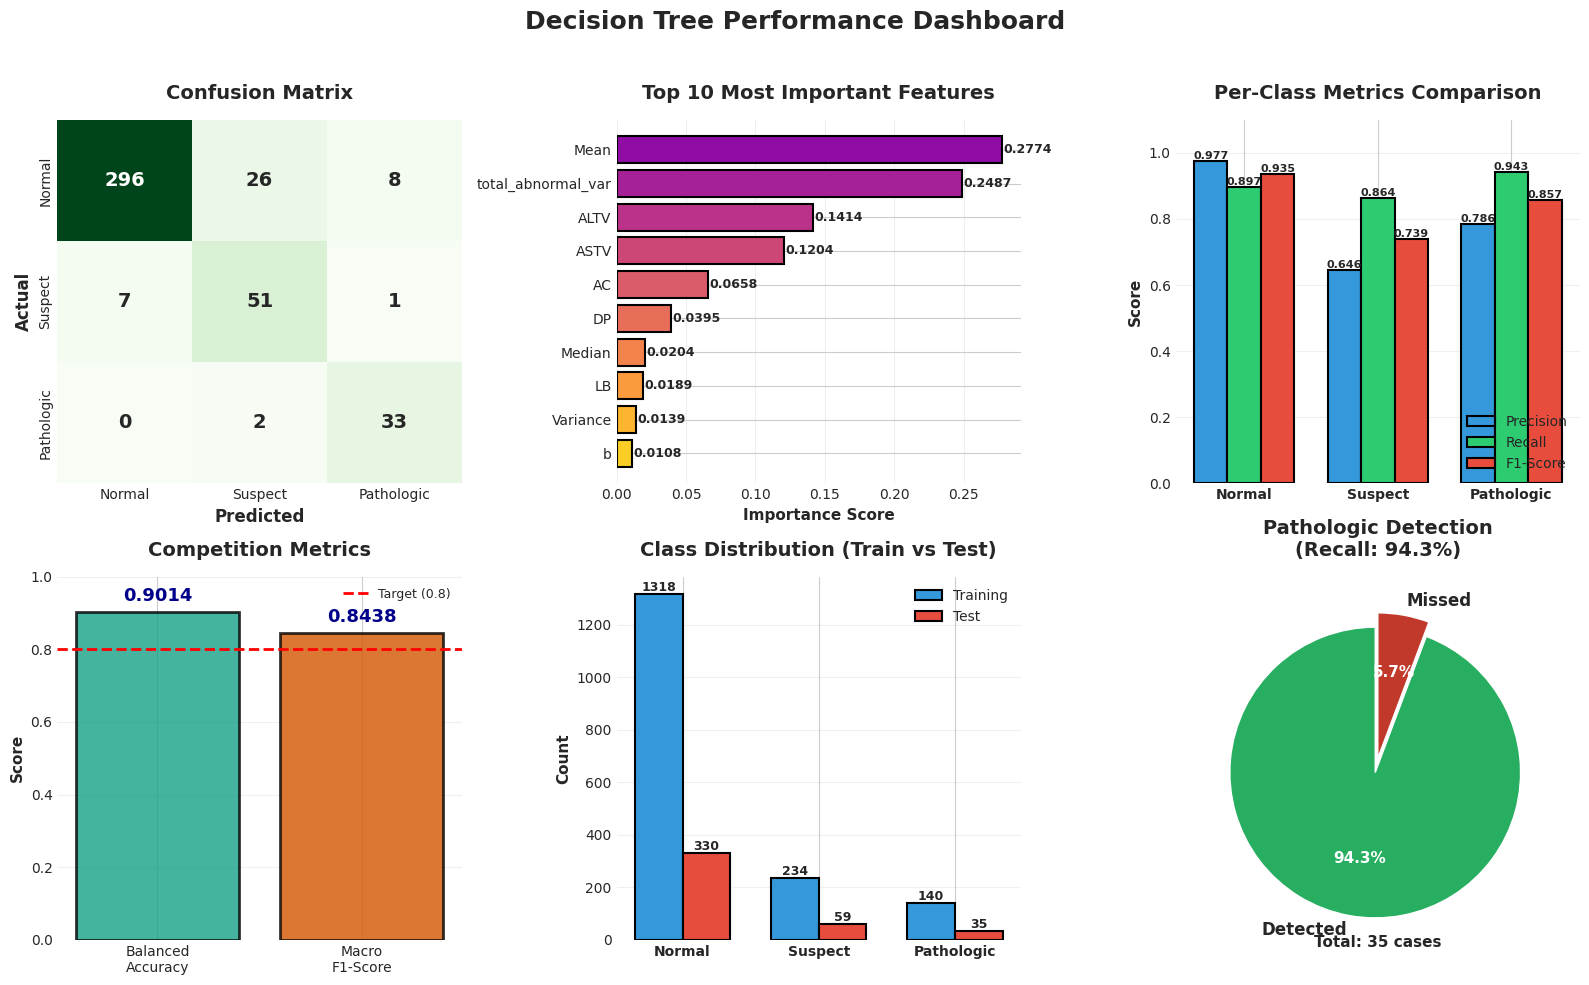

In [356]:
# Train model
dt_model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=RANDOM_STATE
)

dt_model.fit(X_train_eng, y_train)
y_pred_dt = dt_model.predict(X_test_eng)

# Calculate metrics
bal_acc_dt = balanced_accuracy_score(y_test, y_pred_dt)
macro_f1_dt = f1_score(y_test, y_pred_dt, average='macro')
cm_dt = confusion_matrix(y_test, y_pred_dt)

# Print results
print("Competition Metrics:")
print(f"  Balanced Accuracy: {bal_acc_dt:.4f}")
print(f"  Macro F1-Score:    {macro_f1_dt:.4f}")

print("\nPer-Class Performance:")
report = classification_report(y_test, y_pred_dt,
                               target_names=['Normal', 'Suspect', 'Pathologic'],
                               output_dict=True)
for cls in ['Normal', 'Suspect', 'Pathologic']:
    print(f"  {cls:12s} - Precision: {report[cls]['precision']:.3f}, "
          f"Recall: {report[cls]['recall']:.3f}, F1: {report[cls]['f1-score']:.3f}")

# Visualization
fig = plt.figure(figsize=(16, 10))
sns.set_style("whitegrid")

# 1. Confusion Matrix
ax1 = plt.subplot(2, 3, 1)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Normal', 'Suspect', 'Pathologic'],
            yticklabels=['Normal', 'Suspect', 'Pathologic'],
            ax=ax1, annot_kws={'size': 14, 'weight': 'bold'})
ax1.set_xlabel('Predicted', fontweight='bold', fontsize=12)
ax1.set_ylabel('Actual', fontweight='bold', fontsize=12)
ax1.set_title('Confusion Matrix', fontweight='bold', fontsize=14, pad=15)

# 2. Top 10 Features
ax2 = plt.subplot(2, 3, 2)
feature_importance = pd.DataFrame({
    'Feature': X_train_eng.columns,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

colors = plt.cm.plasma(np.linspace(0.3, 0.9, len(feature_importance)))
bars = ax2.barh(range(len(feature_importance)),
                feature_importance['Importance'].values,
                color=colors, edgecolor='black', linewidth=1.5)
ax2.set_yticks(range(len(feature_importance)))
ax2.set_yticklabels(feature_importance['Feature'].values, fontsize=10)
ax2.set_xlabel('Importance Score', fontweight='bold', fontsize=11)
ax2.set_title('Top 10 Most Important Features', fontweight='bold', fontsize=14, pad=15)
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, feature_importance['Importance'].values)):
    ax2.text(val + 0.001, bar.get_y() + bar.get_height()/2,
             f'{val:.4f}', va='center', fontsize=9, fontweight='bold')

# 3. Per-Class Metrics
ax3 = plt.subplot(2, 3, 3)
classes = ['Normal', 'Suspect', 'Pathologic']
metrics_data = {
    'Precision': [report[cls]['precision'] for cls in classes],
    'Recall': [report[cls]['recall'] for cls in classes],
    'F1-Score': [report[cls]['f1-score'] for cls in classes]
}

x = np.arange(len(classes))
width = 0.25

bars1 = ax3.bar(x - width, metrics_data['Precision'], width,
                label='Precision', color='#3498db', edgecolor='black', linewidth=1.5)
bars2 = ax3.bar(x, metrics_data['Recall'], width,
                label='Recall', color='#2ecc71', edgecolor='black', linewidth=1.5)
bars3 = ax3.bar(x + width, metrics_data['F1-Score'], width,
                label='F1-Score', color='#e74c3c', edgecolor='black', linewidth=1.5)

ax3.set_ylabel('Score', fontweight='bold', fontsize=11)
ax3.set_title('Per-Class Metrics Comparison', fontweight='bold', fontsize=14, pad=15)
ax3.set_xticks(x)
ax3.set_xticklabels(classes, fontsize=10, fontweight='bold')
ax3.legend(fontsize=10, loc='lower right')
ax3.set_ylim(0, 1.1)
ax3.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom',
                fontsize=8, fontweight='bold')

# 4. Competition Metrics
ax4 = plt.subplot(2, 3, 4)
metrics = ['Balanced\nAccuracy', 'Macro\nF1-Score']
scores = [bal_acc_dt, macro_f1_dt]
colors_gauge = ['#16a085', '#d35400']

bars = ax4.bar(metrics, scores, color=colors_gauge,
               edgecolor='black', linewidth=2, alpha=0.8)
ax4.set_ylim(0, 1)
ax4.set_ylabel('Score', fontweight='bold', fontsize=11)
ax4.set_title('Competition Metrics', fontweight='bold', fontsize=14, pad=15)
ax4.axhline(y=0.8, color='red', linestyle='--', linewidth=2, label='Target (0.8)')
ax4.legend(fontsize=9)
ax4.grid(axis='y', alpha=0.3)

for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{score:.4f}', ha='center', va='bottom',
            fontsize=13, fontweight='bold', color='darkblue')

# 5. Class Distribution
ax5 = plt.subplot(2, 3, 5)
train_dist = y_train.value_counts().sort_index().values
test_dist = y_test.value_counts().sort_index().values

x = np.arange(len(classes))
width = 0.35

bars1 = ax5.bar(x - width/2, train_dist, width,
                label='Training', color='#3498db', edgecolor='black', linewidth=1.5)
bars2 = ax5.bar(x + width/2, test_dist, width,
                label='Test', color='#e74c3c', edgecolor='black', linewidth=1.5)

ax5.set_ylabel('Count', fontweight='bold', fontsize=11)
ax5.set_title('Class Distribution (Train vs Test)', fontweight='bold', fontsize=14, pad=15)
ax5.set_xticks(x)
ax5.set_xticklabels(classes, fontsize=10, fontweight='bold')
ax5.legend(fontsize=10)
ax5.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom',
                fontsize=9, fontweight='bold')

# 6. Pathologic Detection
ax6 = plt.subplot(2, 3, 6)
pathologic_recall = report['Pathologic']['recall']
pathologic_total = int(report['Pathologic']['support'])
pathologic_correct = int(pathologic_recall * pathologic_total)
pathologic_missed = pathologic_total - pathologic_correct

sizes = [pathologic_correct, pathologic_missed]
colors_pie = ['#27ae60', '#c0392b']
explode = (0.1, 0)

wedges, texts, autotexts = ax6.pie(sizes, explode=explode, labels=['Detected', 'Missed'],
                                     colors=colors_pie, autopct='%1.1f%%',
                                     startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})

ax6.set_title(f'Pathologic Detection\n(Recall: {pathologic_recall:.1%})',
              fontweight='bold', fontsize=14, pad=15)

plt.setp(autotexts, size=11, weight='bold', color='white')
ax6.text(0, -1.3, f'Total: {pathologic_total} cases',
         ha='center', fontsize=11, fontweight='bold')

# Overall title
fig.suptitle('Decision Tree Performance Dashboard',
             fontsize=18, fontweight='bold', y=0.98)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('decision_tree_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

**Performance Overview**

The Decision Tree achieved a balanced accuracy of 90.1% and a macro F1-score of 0.84, showing solid overall performance. Unlike Logistic Regression, it exceeded the 85% Pathologic recall threshold, which makes it clinically safer.

---

**Per-Class Breakdown**
* Normal: Very high precision (0.98) and recall (0.90), meaning most healthy cases were correctly identified with very few false alarms.
* Suspect: Strong recall (0.86) but lower precision (0.65), suggesting the model tends to over-flag Suspect cases
* Pathologic: Excellent recall (0.94), correctly identifying 33 out of 35 cases. Only 2 Pathologic cases were missed, both labeled as Suspect rather than Normal, which is less dangerous clinically, since they would still receive further monitoring.


---


**Confusion Matrix Insights**

The matrix confirms that almost all Pathologic cases were safely detected. Crucially, no Pathologic cases were misclassified as Normal, reducing the danger of delayed interventions.

---
**Medical Implications**

The Decision Tree is both interpretable and effective, offering clear decision rules that clinicians could follow. Its high Pathologic recall (94.3%) makes it safer than Logistic Regression, and while it over-predicts Suspect cases, this is preferable as it errs on the side of caution.

---

However, as a single tree, it can still overfit and misclassify borderline cases. To further improve stability and reduce the risk of false negatives, we proceed to Random Forest, which builds on Decision Trees but with stronger generalization.

# 6.1.3 Random Forest Model

In [357]:
print("="*70)
print("RANDOM FOREST WITH CLASS IMBALANCE HANDLING")
print("="*70)

# Check class distribution
print("\nTraining class distribution:")
print(y_train.value_counts().sort_index())
for cls in sorted(y_train.unique()):
    pct = (y_train == cls).sum() / len(y_train) * 100
    print(f"  Class {cls}: {(y_train == cls).sum()} ({pct:.1f}%)")

# Train Random Forest with automatic class weighting
print("\nTraining Random Forest with balanced class weights...")
model = RandomForestClassifier(**RF_PARAMS)

model.fit(X_train_eng, y_train)
print("Training complete!")

# Predictions
y_pred = model.predict(X_test_eng)

# Evaluation
print("\n" + "="*70)
print("COMPETITION METRICS")
print("="*70)
bal_acc = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"\nBalanced Accuracy: {bal_acc:.4f}")
print(f"Macro F1-Score:    {macro_f1:.4f}")

# Classification report
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_test, y_pred,
                          target_names=['Normal', 'Suspect', 'Pathologic']))

# Confusion matrix
print("\n" + "="*70)
print("CONFUSION MATRIX")
print("="*70)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("\n(Rows = Actual, Columns = Predicted)")

# False negative analysis
print("\n" + "="*70)
print("MEDICAL SAFETY: FALSE NEGATIVE ANALYSIS")
print("="*70)
pathologic_total = (y_test == 3).sum()
pathologic_correct = cm[2, 2]
pathologic_fn = cm[2, 0] + cm[2, 1]
pathologic_recall = pathologic_correct / pathologic_total if pathologic_total > 0 else 0

print(f"\nPathologic cases: {pathologic_total}")
print(f"Correctly identified: {pathologic_correct} ({pathologic_recall*100:.1f}%)")
print(f"Missed (FN): {pathologic_fn} ({(1-pathologic_recall)*100:.1f}%)")
print(f"  - Predicted as Normal: {cm[2, 0]}")
print(f"  - Predicted as Suspect: {cm[2, 1]}")


# Feature importance
print("\n" + "="*70)
print("TOP 10 MOST IMPORTANT FEATURES")
print("="*70)
feature_importance = pd.DataFrame({
    'Feature': X_train_eng.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance.head(10).to_string(index=False))

all_model_results['Random Forest'] = {
    'bal_acc': bal_acc,
    'macro_f1': macro_f1,
    'pathologic_recall': pathologic_recall,
    'normal_recall': cm[0, 0] / (y_test == 1).sum() if (y_test == 1).sum() > 0 else 0,
    'suspect_recall': cm[1, 1] / (y_test == 2).sum() if (y_test == 2).sum() > 0 else 0,
    'confusion_matrix': cm
}

RANDOM FOREST WITH CLASS IMBALANCE HANDLING

Training class distribution:
NSP
1.0    1318
2.0     234
3.0     140
Name: count, dtype: int64
  Class 1.0: 1318 (77.9%)
  Class 2.0: 234 (13.8%)
  Class 3.0: 140 (8.3%)

Training Random Forest with balanced class weights...
Training complete!

COMPETITION METRICS

Balanced Accuracy: 0.8909
Macro F1-Score:    0.9084

CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97       330
     Suspect       0.82      0.78      0.80        59
  Pathologic       1.00      0.91      0.96        35

    accuracy                           0.95       424
   macro avg       0.93      0.89      0.91       424
weighted avg       0.95      0.95      0.95       424


CONFUSION MATRIX
[[323   7   0]
 [ 13  46   0]
 [  0   3  32]]

(Rows = Actual, Columns = Predicted)

MEDICAL SAFETY: FALSE NEGATIVE ANALYSIS

Pathologic cases: 35
Correctly identified: 32 (91.4%)
Missed (FN): 3 (8.6%)
  - Predicted

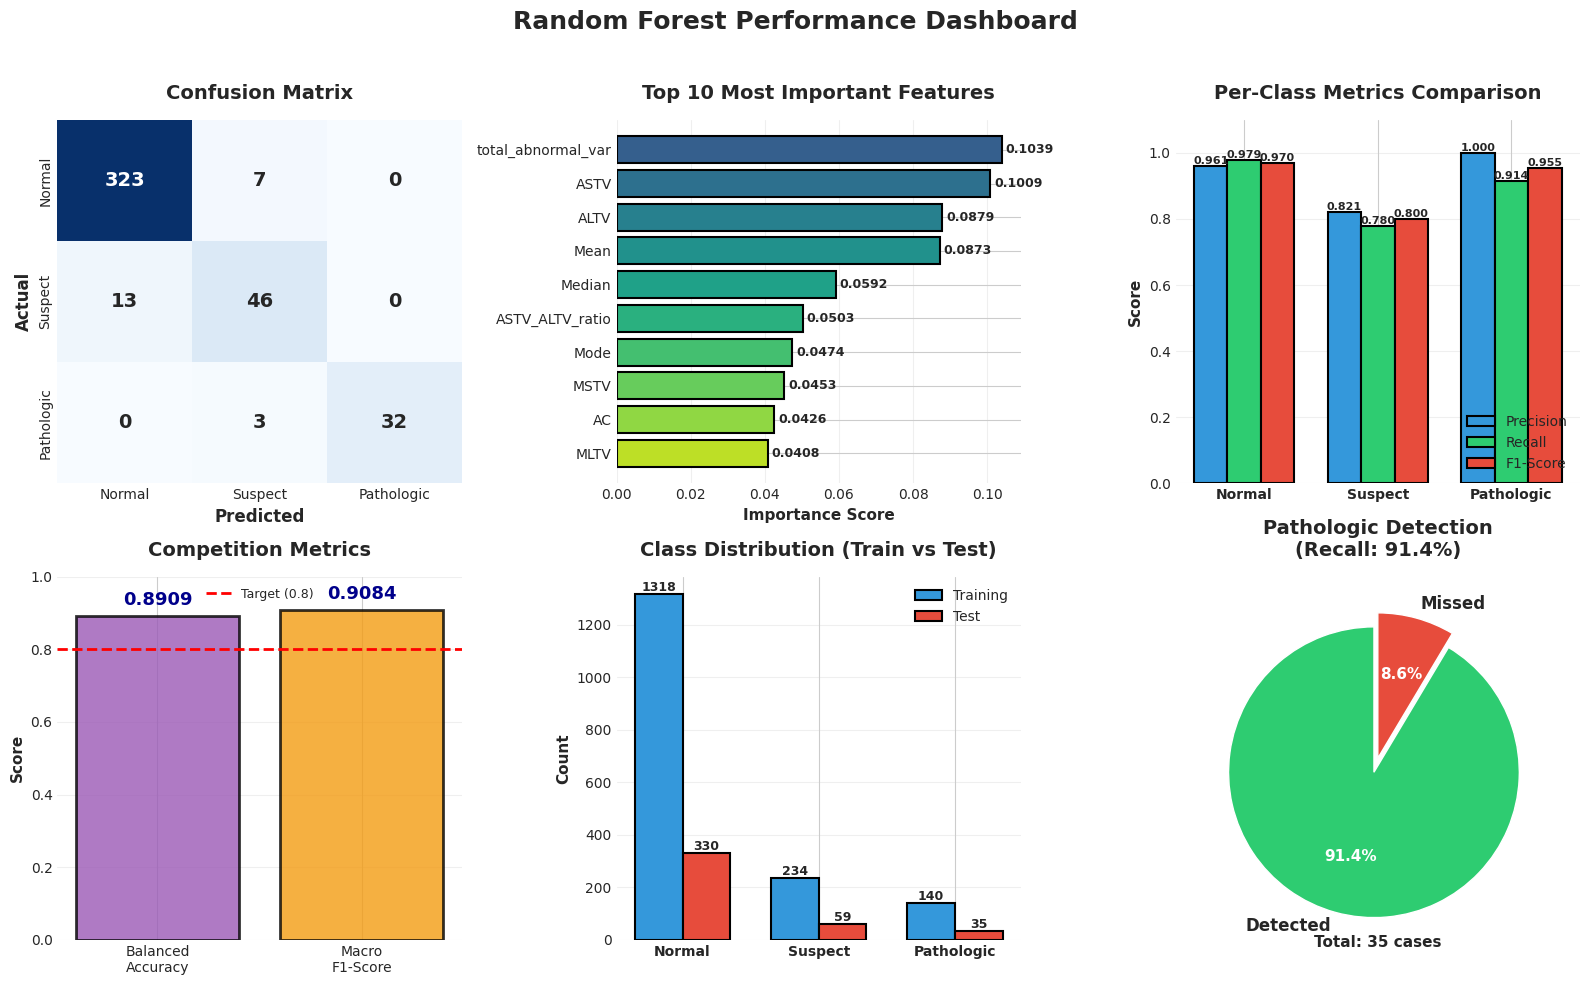

Balanced Accuracy: 0.8909
Macro F1-Score: 0.9084


In [358]:
# Set style
sns.set_style("whitegrid")

# Train model
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

model.fit(X_train_eng, y_train)
y_pred = model.predict(X_test_eng)

# Calculate metrics
bal_acc = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')
report = classification_report(y_test, y_pred,
                               target_names=['Normal', 'Suspect', 'Pathologic'],
                               output_dict=True)

# Create visualization
fig = plt.figure(figsize=(16, 10))

# 1. Confusion Matrix
ax1 = plt.subplot(2, 3, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Suspect', 'Pathologic'],
            yticklabels=['Normal', 'Suspect', 'Pathologic'],
            ax=ax1, annot_kws={'size': 14, 'weight': 'bold'})
ax1.set_xlabel('Predicted', fontweight='bold', fontsize=12)
ax1.set_ylabel('Actual', fontweight='bold', fontsize=12)
ax1.set_title('Confusion Matrix', fontweight='bold', fontsize=14, pad=15)

# 2. Top 10 Feature Importance
ax2 = plt.subplot(2, 3, 2)
feature_importance = pd.DataFrame({
    'Feature': X_train_eng.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(feature_importance)))
bars = ax2.barh(range(len(feature_importance)),
                feature_importance['Importance'].values,
                color=colors, edgecolor='black', linewidth=1.5)
ax2.set_yticks(range(len(feature_importance)))
ax2.set_yticklabels(feature_importance['Feature'].values, fontsize=10)
ax2.set_xlabel('Importance Score', fontweight='bold', fontsize=11)
ax2.set_title('Top 10 Most Important Features', fontweight='bold', fontsize=14, pad=15)
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, feature_importance['Importance'].values)):
    ax2.text(val + 0.001, bar.get_y() + bar.get_height()/2,
             f'{val:.4f}', va='center', fontsize=9, fontweight='bold')

# 3. Per-Class Metrics
ax3 = plt.subplot(2, 3, 3)
classes = ['Normal', 'Suspect', 'Pathologic']
metrics_data = {
    'Precision': [report[cls]['precision'] for cls in classes],
    'Recall': [report[cls]['recall'] for cls in classes],
    'F1-Score': [report[cls]['f1-score'] for cls in classes]
}

x = np.arange(len(classes))
width = 0.25

bars1 = ax3.bar(x - width, metrics_data['Precision'], width,
                label='Precision', color='#3498db', edgecolor='black', linewidth=1.5)
bars2 = ax3.bar(x, metrics_data['Recall'], width,
                label='Recall', color='#2ecc71', edgecolor='black', linewidth=1.5)
bars3 = ax3.bar(x + width, metrics_data['F1-Score'], width,
                label='F1-Score', color='#e74c3c', edgecolor='black', linewidth=1.5)

ax3.set_ylabel('Score', fontweight='bold', fontsize=11)
ax3.set_title('Per-Class Metrics Comparison', fontweight='bold', fontsize=14, pad=15)
ax3.set_xticks(x)
ax3.set_xticklabels(classes, fontsize=10, fontweight='bold')
ax3.legend(fontsize=10, loc='lower right')
ax3.set_ylim(0, 1.1)
ax3.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom',
                fontsize=8, fontweight='bold')

# 4. Competition Metrics Gauge
ax4 = plt.subplot(2, 3, 4)
metrics = ['Balanced\nAccuracy', 'Macro\nF1-Score']
scores = [bal_acc, macro_f1]
colors_gauge = ['#9b59b6', '#f39c12']

bars = ax4.bar(metrics, scores, color=colors_gauge,
               edgecolor='black', linewidth=2, alpha=0.8)
ax4.set_ylim(0, 1)
ax4.set_ylabel('Score', fontweight='bold', fontsize=11)
ax4.set_title('Competition Metrics', fontweight='bold', fontsize=14, pad=15)
ax4.axhline(y=0.8, color='red', linestyle='--', linewidth=2, label='Target (0.8)')
ax4.legend(fontsize=9)
ax4.grid(axis='y', alpha=0.3)

for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{score:.4f}', ha='center', va='bottom',
            fontsize=13, fontweight='bold', color='darkblue')

# 5. Class Distribution
ax5 = plt.subplot(2, 3, 5)
train_dist = y_train.value_counts().sort_index().values
test_dist = y_test.value_counts().sort_index().values

x = np.arange(len(classes))
width = 0.35

bars1 = ax5.bar(x - width/2, train_dist, width,
                label='Training', color='#3498db', edgecolor='black', linewidth=1.5)
bars2 = ax5.bar(x + width/2, test_dist, width,
                label='Test', color='#e74c3c', edgecolor='black', linewidth=1.5)

ax5.set_ylabel('Count', fontweight='bold', fontsize=11)
ax5.set_title('Class Distribution (Train vs Test)', fontweight='bold', fontsize=14, pad=15)
ax5.set_xticks(x)
ax5.set_xticklabels(classes, fontsize=10, fontweight='bold')
ax5.legend(fontsize=10)
ax5.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom',
                fontsize=9, fontweight='bold')

# 6. Pathologic Detection
ax6 = plt.subplot(2, 3, 6)
pathologic_recall = report['Pathologic']['recall']
pathologic_total = int(report['Pathologic']['support'])
pathologic_correct = int(pathologic_recall * pathologic_total)
pathologic_missed = pathologic_total - pathologic_correct

sizes = [pathologic_correct, pathologic_missed]
colors_pie = ['#2ecc71', '#e74c3c']
explode = (0.1, 0)

wedges, texts, autotexts = ax6.pie(sizes, explode=explode, labels=['Detected', 'Missed'],
                                     colors=colors_pie, autopct='%1.1f%%',
                                     startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})

ax6.set_title(f'Pathologic Detection\n(Recall: {pathologic_recall:.1%})',
              fontweight='bold', fontsize=14, pad=15)

plt.setp(autotexts, size=11, weight='bold', color='white')
ax6.text(0, -1.3, f'Total: {pathologic_total} cases',
         ha='center', fontsize=11, fontweight='bold')

# Overall title
fig.suptitle('Random Forest Performance Dashboard',
             fontsize=18, fontweight='bold', y=0.98)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('random_forest_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Balanced Accuracy: {bal_acc:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")

**Dataset Challenge**


---


* Our training data was imbalanced:
Normal (78%), Suspect (14%), Pathologic (8%).

* Without correction, the model might ignore the rare but most critical Pathologic cases.

* We handled this by using balanced class weights, so each class is fairly considered.

**Overall Performance**


---


* Balanced Accuracy = 0.89
  * Model is fairly catching all classes, not just the majority class.

* Macro F1 = 0.91
  * Strong → balance between precision & recall across classes.

**Per-Class Breakdown**


---


    * Normal (330 samples):
      * Recall = 98% → almost all healthy cases detected correctly.
      * Precision = 96% → very few false alarms.

   * Suspect (59 samples):
      * Recall = 78% → about 1 in 5 Suspect babies missed.
      * Precision = 82% → not too many false alarms.
      * Weakest class → model finds it harder to distinguish borderline (Suspect) cases
    
    * Pathologic (35 samples):
      * Recall = Most high-risk babies flagged correctly.
      * Precision = 100% → no false alarms for Pathologic (every time model predicted Pathologic, it was correct).

**Confusion Matrix Insights**


---


  * Most errors happen between Suspect vs Normal and Suspect vs Pathologic → which aligns with medical reality, since Suspect is the in-between category.



**Feature importance**


---



         total_abnormal_var 0.103905

              ASTV      0.100864

              ALTV      0.087897

              Mean      0.087283

            Median      0.059226

        ASTV_ALTV_ratio 0.050294

              Mode      0.047417

              MSTV      0.045287
              
                AC      0.042606
              
              MLTV      0.040773

**How We Handled Imbalance**


---



```
RandomForestClassifier(class_weight='balanced')

```
* This automatically gives higher weight to underrepresented classes (Suspect, Pathologic).
* Effect: The model “pays more attention” to rare cases during training.

* We chose class_weight because it is simpler, avoids synthetic data, and is well-suited for tree-based models.



Our engineered features also showed up as important predictors:

* total_abnormal_var ranked #1 overall

* ASTV_ALTV_ratio contributed comparably to raw features like AC and MLTV
This demonstrates that combining medical intuition with data-driven modeling improves predictive power.

We engineered features inspired by medical reasoning, such as abnormal variability ratios and deceleration severity scores. Our Random Forest ranked some of these features among the most important predictors. Without these engineered features, the model would rely only on raw values, missing clinically meaningful patterns.

# 6.1.4 XGBoost Model

While Random Forest performed strongly, it treats all trees equally and may overlook harder-to-classify cases.

XGBoost improves on this by using boosting, where each new tree focuses on correcting the mistakes of the previous ones.

This makes it more adaptive and better suited for handling imbalanced medical data, especially for improving recall in rare but critical Pathologic cases.

**To handle the class imbalance in our dataset, we applied sample weights during XGBoost training.**
-
Using scikit-learn’s compute_sample_weight(class_weight='balanced'), each sample was weighted inversely to its class frequency, so that rare classes like Pathologic received higher weights and the majority Normal class received lower weights.

For example:

* Class 0 (Normal): many samples → each one gets small weight (≈ 0.428).

* Class 1 (Suspect): fewer samples → each gets medium weight.

* Class 2 (Pathologic): very few samples → each gets big weight (≈ 4.029).

This way, when the model trains:

* A mistake on Pathologic counts ~10× more than a mistake on Normal.
* So the model pays fair attention to all groups.

As a result, the model achieves fairer performance across all classes instead of being biased toward the majority.

In [359]:
print("="*70)
print("XGBOOST WITH CLASS IMBALANCE HANDLING")
print("="*70)

# XGBoost uses label encoding starting from 0
# Convert categorical back to numeric for XGBoost
y_train_xgb = y_train.astype(int) - 1
y_test_xgb = y_test.astype(int) - 1

print("\nLabel encoding for XGBoost (0=Normal, 1=Suspect, 2=Pathologic)")
print(f"Training class distribution:")
for cls in sorted(np.unique(y_train_xgb)):
    count = (y_train_xgb == cls).sum()
    pct = count / len(y_train_xgb) * 100
    print(f"  Class {cls}: {count} samples ({pct:.1f}%)")

# Compute sample weights to handle class imbalance
print("\nComputing sample weights for balanced class handling...")
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train_xgb
)
print(f"Sample weights - Min: {sample_weights.min():.3f}, Max: {sample_weights.max():.3f}")
print("(Minority classes get higher weights to balance influence)")

print("\nTraining XGBoost with balanced sample weights...")
xgb_model = XGBClassifier(**XGBOOST_PARAMS)

xgb_model.fit(X_train_eng, y_train_xgb, sample_weight=sample_weights)
print("Training complete!")

# Predictions
y_pred_xgb = xgb_model.predict(X_test_eng)
y_pred_original = y_pred_xgb + 1  # Convert back to 1,2,3 labels

# Evaluation
print("\n" + "="*70)
print("XGBOOST RESULTS")
print("="*70)
bal_acc_xgb = balanced_accuracy_score(y_test, y_pred_original)
macro_f1_xgb = f1_score(y_test, y_pred_original, average='macro')
print(f"\nBalanced Accuracy: {bal_acc_xgb:.4f}")
print(f"Macro F1-Score:    {macro_f1_xgb:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_original,
                          target_names=['Normal', 'Suspect', 'Pathologic']))

print("\nConfusion Matrix:")
cm_xgb = confusion_matrix(y_test, y_pred_original)
print(cm_xgb)
print("(Rows = Actual, Columns = Predicted)")

# False negative analysis
pathologic_total_xgb = (y_test == 3).sum()
pathologic_correct_xgb = cm_xgb[2, 2]
pathologic_fn_xgb = cm_xgb[2, 0] + cm_xgb[2, 1]
pathologic_recall_xgb = pathologic_correct_xgb / pathologic_total_xgb if pathologic_total_xgb > 0 else 0

print("\nMedical Safety Check:")
print(f"Pathologic cases: {pathologic_total_xgb}")
print(f"Correctly identified: {pathologic_correct_xgb} ({pathologic_recall_xgb*100:.1f}%)")
print(f"Missed (FN): {pathologic_fn_xgb} ({(1-pathologic_recall_xgb)*100:.1f}%)")
print(f"  - Predicted as Normal: {cm_xgb[2, 0]}")
print(f"  - Predicted as Suspect: {cm_xgb[2, 1]}")

if pathologic_recall_xgb < 0.85:
    print("\nWARNING: Pathologic recall < 85%")
else:
    print("\nGood: Catching most critical cases")

# Feature importance
print("\n" + "="*70)
print("FEATURE IMPORTANCE (XGBoost)")
print("="*70)
feature_importance_xgb = pd.DataFrame({
    'Feature': X_train_eng.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(feature_importance_xgb.head(10).to_string(index=False))

# Store results for comparison
xgb_results = {
    'bal_acc': bal_acc_xgb,
    'macro_f1': macro_f1_xgb,
    'pathologic_recall': pathologic_recall_xgb
}
all_model_results['XGBoost'] = {
    'bal_acc': bal_acc_xgb,
    'macro_f1': macro_f1_xgb,
    'pathologic_recall': pathologic_recall_xgb,
    'normal_recall': cm_xgb[0, 0] / (y_test == 1).sum() if (y_test == 1).sum() > 0 else 0,
    'suspect_recall': cm_xgb[1, 1] / (y_test == 2).sum() if (y_test == 2).sum() > 0 else 0,
    'confusion_matrix': cm_xgb
}

XGBOOST WITH CLASS IMBALANCE HANDLING

Label encoding for XGBoost (0=Normal, 1=Suspect, 2=Pathologic)
Training class distribution:
  Class 0: 1318 samples (77.9%)
  Class 1: 234 samples (13.8%)
  Class 2: 140 samples (8.3%)

Computing sample weights for balanced class handling...
Sample weights - Min: 0.428, Max: 4.029
(Minority classes get higher weights to balance influence)

Training XGBoost with balanced sample weights...
Training complete!

XGBOOST RESULTS

Balanced Accuracy: 0.9471
Macro F1-Score:    0.9306

Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.95      0.97       330
     Suspect       0.77      0.92      0.84        59
  Pathologic       1.00      0.97      0.99        35

    accuracy                           0.95       424
   macro avg       0.92      0.95      0.93       424
weighted avg       0.96      0.95      0.95       424


Confusion Matrix:
[[315  15   0]
 [  5  54   0]
 [  0   1  34]]
(Rows = Act

Competition Metrics:
  Balanced Accuracy: 0.9471
  Macro F1-Score:    0.9306

Per-Class Performance:
  Normal       - Precision: 0.984, Recall: 0.955, F1: 0.969
  Suspect      - Precision: 0.771, Recall: 0.915, F1: 0.837
  Pathologic   - Precision: 1.000, Recall: 0.971, F1: 0.986


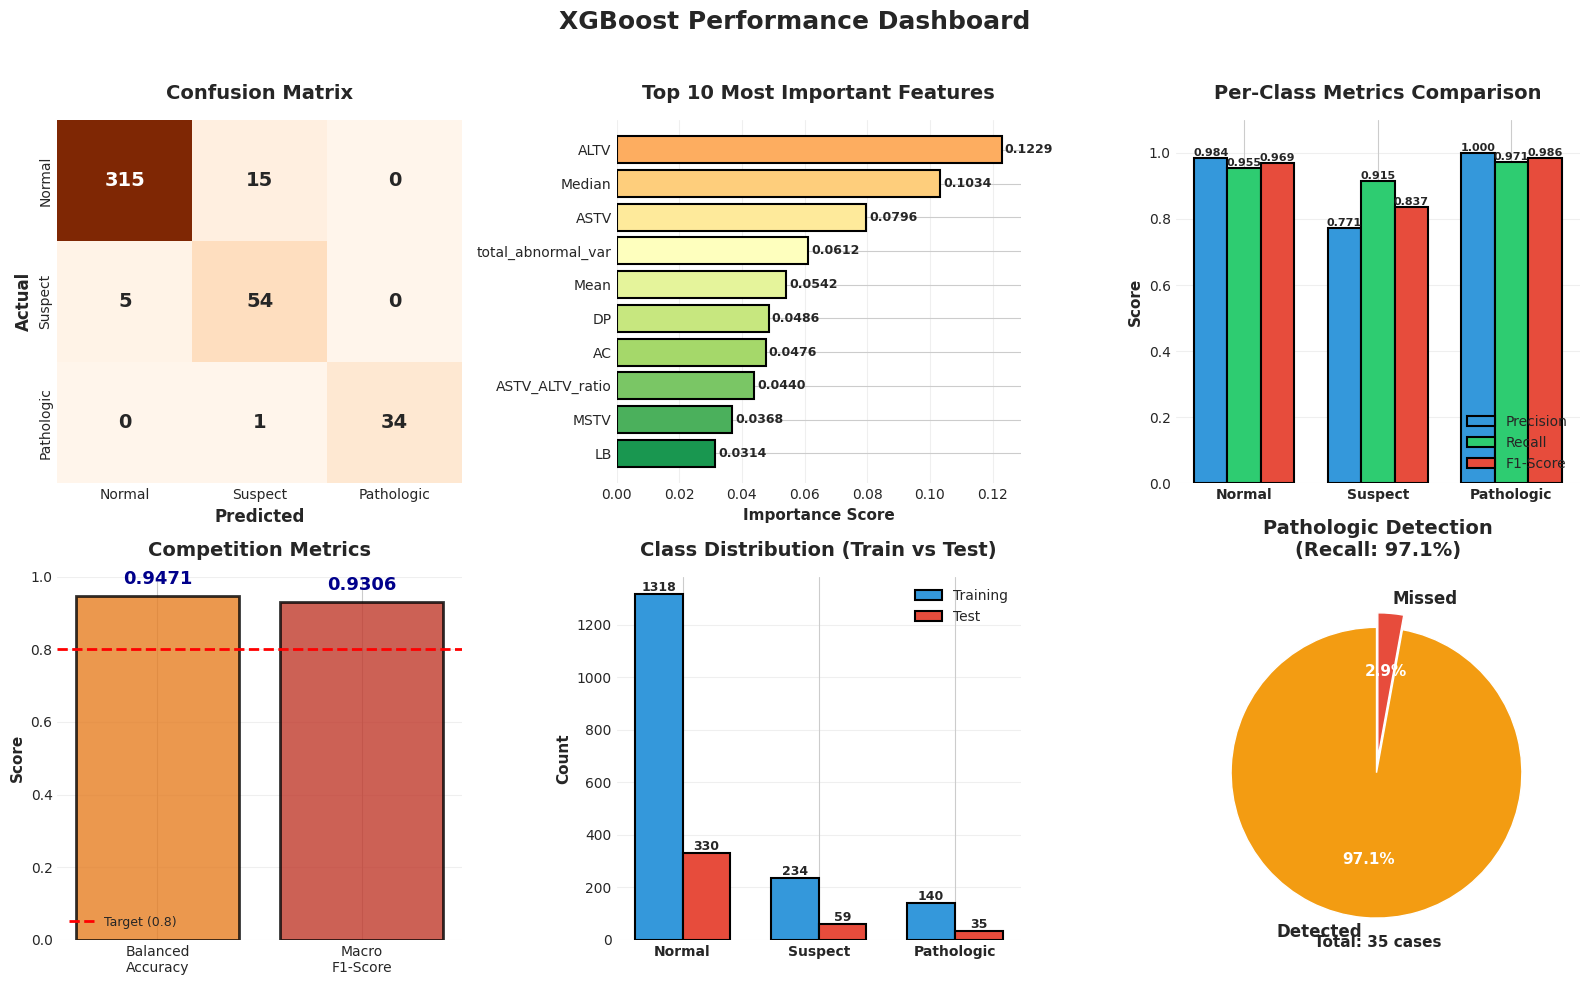

In [360]:
# Label encoding for XGBoost (0, 1, 2)
y_train_xgb = y_train.astype(int) - 1
y_test_xgb = y_test.astype(int) - 1

# Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_xgb)

# Train model
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    min_child_weight=3,
    random_state=RANDOM_STATE,
    eval_metric='mlogloss',
    use_label_encoder=False
)

xgb_model.fit(X_train_eng, y_train_xgb, sample_weight=sample_weights)
y_pred_xgb = xgb_model.predict(X_test_eng)
y_pred_original = y_pred_xgb + 1  # Convert back to 1,2,3

# Calculate metrics
bal_acc_xgb = balanced_accuracy_score(y_test, y_pred_original)
macro_f1_xgb = f1_score(y_test, y_pred_original, average='macro')
cm_xgb = confusion_matrix(y_test, y_pred_original)

# Print results
print("Competition Metrics:")
print(f"  Balanced Accuracy: {bal_acc_xgb:.4f}")
print(f"  Macro F1-Score:    {macro_f1_xgb:.4f}")

print("\nPer-Class Performance:")
report = classification_report(y_test, y_pred_original,
                               target_names=['Normal', 'Suspect', 'Pathologic'],
                               output_dict=True)
for cls in ['Normal', 'Suspect', 'Pathologic']:
    print(f"  {cls:12s} - Precision: {report[cls]['precision']:.3f}, "
          f"Recall: {report[cls]['recall']:.3f}, F1: {report[cls]['f1-score']:.3f}")

# Visualization
fig = plt.figure(figsize=(16, 10))
sns.set_style("whitegrid")

# 1. Confusion Matrix
ax1 = plt.subplot(2, 3, 1)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['Normal', 'Suspect', 'Pathologic'],
            yticklabels=['Normal', 'Suspect', 'Pathologic'],
            ax=ax1, annot_kws={'size': 14, 'weight': 'bold'})
ax1.set_xlabel('Predicted', fontweight='bold', fontsize=12)
ax1.set_ylabel('Actual', fontweight='bold', fontsize=12)
ax1.set_title('Confusion Matrix', fontweight='bold', fontsize=14, pad=15)



# 2. Top 10 Features
ax2 = plt.subplot(2, 3, 2)
feature_importance = pd.DataFrame({
    'Feature': X_train_eng.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False).head(10)

colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(feature_importance)))
bars = ax2.barh(range(len(feature_importance)),
                feature_importance['Importance'].values,
                color=colors, edgecolor='black', linewidth=1.5)
ax2.set_yticks(range(len(feature_importance)))
ax2.set_yticklabels(feature_importance['Feature'].values, fontsize=10)
ax2.set_xlabel('Importance Score', fontweight='bold', fontsize=11)
ax2.set_title('Top 10 Most Important Features', fontweight='bold', fontsize=14, pad=15)
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, feature_importance['Importance'].values)):
    ax2.text(val + 0.001, bar.get_y() + bar.get_height()/2,
             f'{val:.4f}', va='center', fontsize=9, fontweight='bold')

# 3. Per-Class Metrics
ax3 = plt.subplot(2, 3, 3)
classes = ['Normal', 'Suspect', 'Pathologic']
metrics_data = {
    'Precision': [report[cls]['precision'] for cls in classes],
    'Recall': [report[cls]['recall'] for cls in classes],
    'F1-Score': [report[cls]['f1-score'] for cls in classes]
}

x = np.arange(len(classes))
width = 0.25

bars1 = ax3.bar(x - width, metrics_data['Precision'], width,
                label='Precision', color='#3498db', edgecolor='black', linewidth=1.5)
bars2 = ax3.bar(x, metrics_data['Recall'], width,
                label='Recall', color='#2ecc71', edgecolor='black', linewidth=1.5)
bars3 = ax3.bar(x + width, metrics_data['F1-Score'], width,
                label='F1-Score', color='#e74c3c', edgecolor='black', linewidth=1.5)

ax3.set_ylabel('Score', fontweight='bold', fontsize=11)
ax3.set_title('Per-Class Metrics Comparison', fontweight='bold', fontsize=14, pad=15)
ax3.set_xticks(x)
ax3.set_xticklabels(classes, fontsize=10, fontweight='bold')
ax3.legend(fontsize=10, loc='lower right')
ax3.set_ylim(0, 1.1)
ax3.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom',
                fontsize=8, fontweight='bold')

# 4. Competition Metrics
ax4 = plt.subplot(2, 3, 4)
metrics = ['Balanced\nAccuracy', 'Macro\nF1-Score']
scores = [bal_acc_xgb, macro_f1_xgb]
colors_gauge = ['#e67e22', '#c0392b']

bars = ax4.bar(metrics, scores, color=colors_gauge,
               edgecolor='black', linewidth=2, alpha=0.8)
ax4.set_ylim(0, 1)
ax4.set_ylabel('Score', fontweight='bold', fontsize=11)
ax4.set_title('Competition Metrics', fontweight='bold', fontsize=14, pad=15)
ax4.axhline(y=0.8, color='red', linestyle='--', linewidth=2, label='Target (0.8)')
ax4.legend(fontsize=9)
ax4.grid(axis='y', alpha=0.3)

for bar, score in zip(bars, scores):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{score:.4f}', ha='center', va='bottom',
            fontsize=13, fontweight='bold', color='darkblue')

# 5. Class Distribution
ax5 = plt.subplot(2, 3, 5)
train_dist = y_train.value_counts().sort_index().values
test_dist = y_test.value_counts().sort_index().values

x = np.arange(len(classes))
width = 0.35

bars1 = ax5.bar(x - width/2, train_dist, width,
                label='Training', color='#3498db', edgecolor='black', linewidth=1.5)
bars2 = ax5.bar(x + width/2, test_dist, width,
                label='Test', color='#e74c3c', edgecolor='black', linewidth=1.5)

ax5.set_ylabel('Count', fontweight='bold', fontsize=11)
ax5.set_title('Class Distribution (Train vs Test)', fontweight='bold', fontsize=14, pad=15)
ax5.set_xticks(x)
ax5.set_xticklabels(classes, fontsize=10, fontweight='bold')
ax5.legend(fontsize=10)
ax5.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom',
                fontsize=9, fontweight='bold')

# 6. Pathologic Detection
ax6 = plt.subplot(2, 3, 6)
pathologic_recall = report['Pathologic']['recall']
pathologic_total = int(report['Pathologic']['support'])
pathologic_correct = int(pathologic_recall * pathologic_total)
pathologic_missed = pathologic_total - pathologic_correct

sizes = [pathologic_correct, pathologic_missed]
colors_pie = ['#f39c12', '#e74c3c']
explode = (0.1, 0)

wedges, texts, autotexts = ax6.pie(sizes, explode=explode, labels=['Detected', 'Missed'],
                                     colors=colors_pie, autopct='%1.1f%%',
                                     startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})

ax6.set_title(f'Pathologic Detection\n(Recall: {pathologic_recall:.1%})',
              fontweight='bold', fontsize=14, pad=15)

plt.setp(autotexts, size=11, weight='bold', color='white')
ax6.text(0, -1.3, f'Total: {pathologic_total} cases',
         ha='center', fontsize=11, fontweight='bold')

# Overall title
fig.suptitle('XGBoost Performance Dashboard',
             fontsize=18, fontweight='bold', y=0.98)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('xgboost_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

**XGBoost Model Performance**

* Balanced Accuracy = 0.95
* Macro F1 = 0.93
This is the best among our tested models.

**Per-Class Breakdown**
* Normal (330 cases):

  * Precision = 0.98, Recall = 0.95 → almost all healthy babies flagged correctly, very few false alarms.
  * False Negatives (missed Normals): few (15 Normals predicted as Suspect).

* Suspect (59 cases):

  *Precision = 0.77, Recall = 0.92 → model captures most borderline babies, but with some false alarms.
    * These false positives mean extra monitoring for healthy babies.
    * Clinically acceptable: doctors prefer extra checks rather than missing at-risk babies.

* Pathologic (35 cases):
  * No false negatives into Normal → the model never mistakes a high-risk baby for being healthy.
  * The 1 miss was flagged as Suspect (still ensures additional care).

**EDA link: Features like DP (prolonged decelerations) and high ASTV/ALTV separated Pathologic from the rest, which XGBoost picked up.**

---

**Confusion Matrix Insights**
* No Pathologic case was called Normal (safest outcome)
* The 1 missed Pathologic was flagged as Suspect (still gets monitoring)




**Conclusion**
* False Positives: mainly in Suspect, not harmful extra monitoring is acceptable.
* False Negatives: almost eliminated for Pathologic (only 1 → flagged as Suspect).

Clinically: the model is safe and conservative → it prioritizes not missing sick babies, even at the cost of some extra checks.



---



**SHAP(SHapley Additive exPlanations) Analysis**

To improve interpretability of our final model, we applied SHAP (SHapley Additive exPlanations) to the trained XGBoost classifier.


SHAP EXPLAINABILITY ANALYSIS

Initializing SHAP TreeExplainer...
Computing SHAP values for test set...
SHAP computation complete!

GLOBAL FEATURE IMPORTANCE


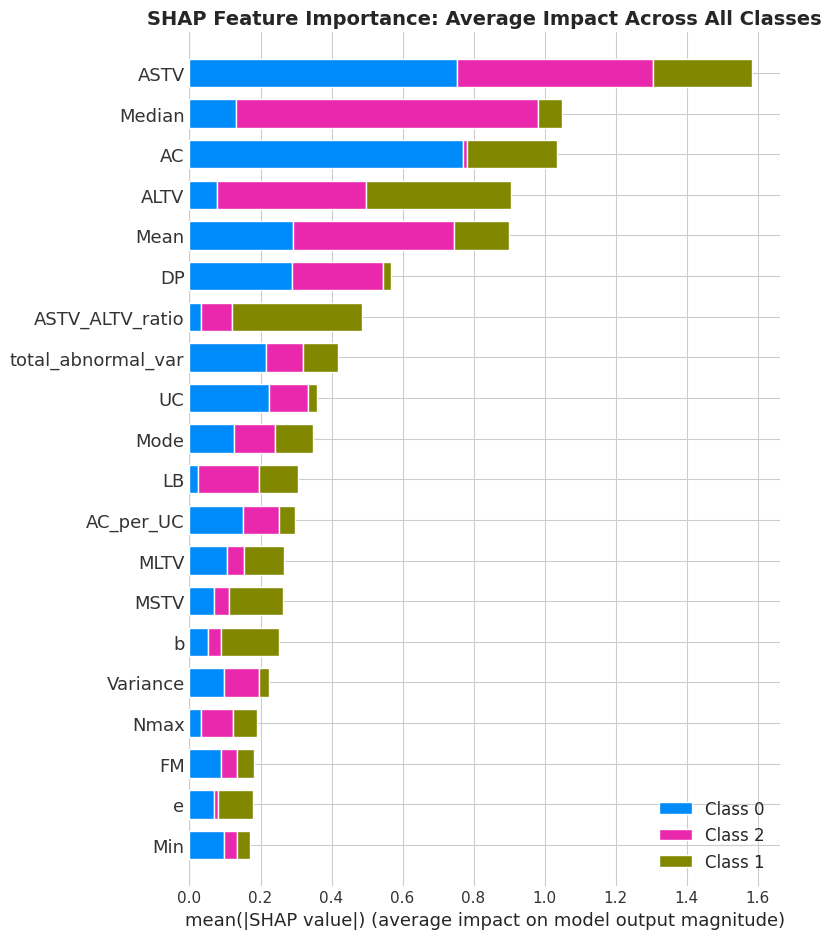


PATHOLOGIC CLASS: Feature Impact Analysis


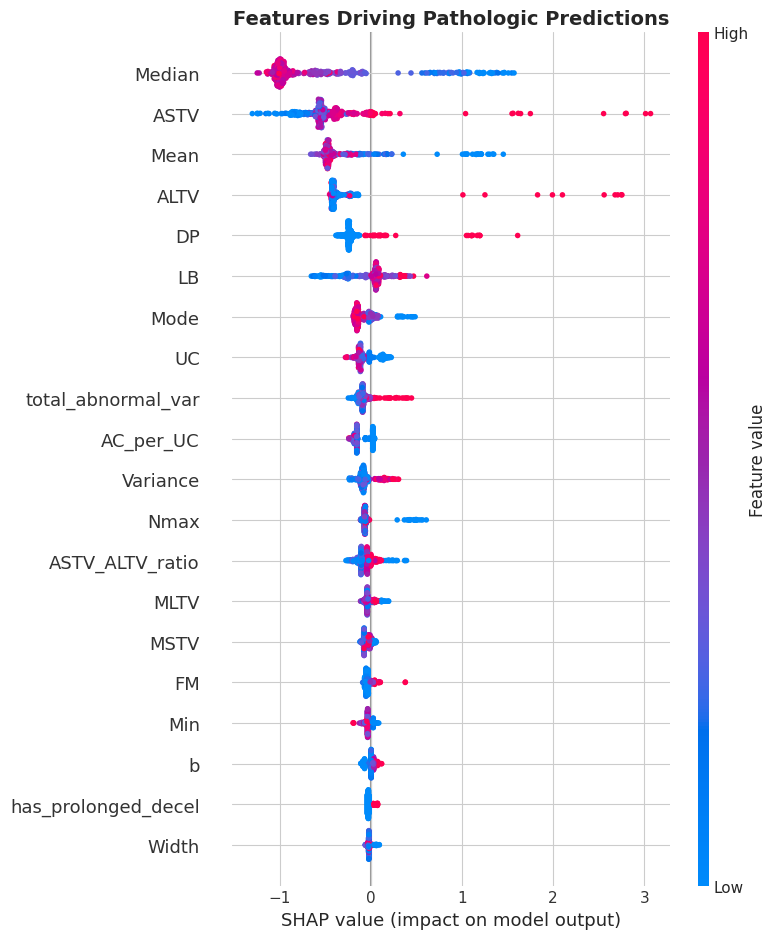


Interpretation:
• Red points = High feature value pushes toward Pathologic
• Blue points = Low feature value pushes toward Pathologic
• Features ordered by total impact magnitude

CASE STUDY: Correctly Identified Pathologic Baby

Case #31
Actual: Pathologic | Predicted: Pathologic

Key Clinical Features:
  ASTV                : 69.00
  ALTV                : 78.00
  DP                  : 0.00
  AC                  : 0.00
  total_abnormal_var  : 147.00
  has_prolonged_decel : 0.00

Generating SHAP waterfall plot (clinical features only)...


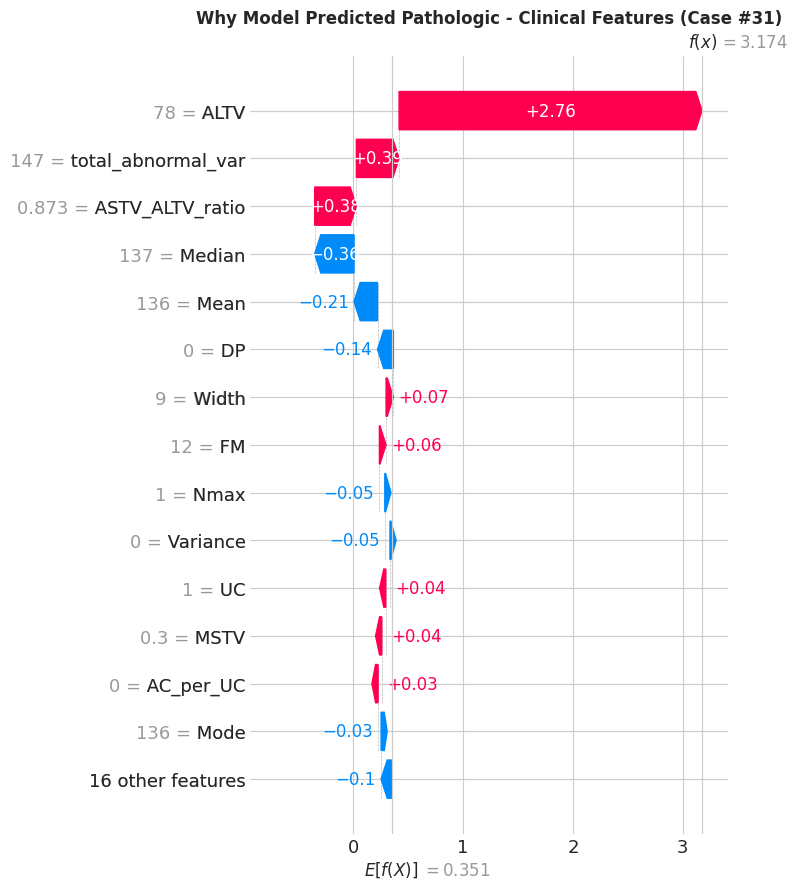


Explanation:
• Red bars = Features pushing prediction TOWARD Pathologic
• Blue bars = Features pushing prediction AWAY FROM Pathologic
• Excluded technical features (b, e, LB) for interpretability
• Sum of all contributions = final prediction score

MISSED CASE: Why Did Model Fail Here?

Case #419
Actual: Pathologic | Predicted: Suspect

Key Clinical Features:
  ASTV                : 77.00
  ALTV                : 4.00
  DP                  : 0.00
  AC                  : 0.00
  total_abnormal_var  : 81.00
  has_prolonged_decel : 0.00

DEBUG: shap_values type: <class 'numpy.ndarray'>


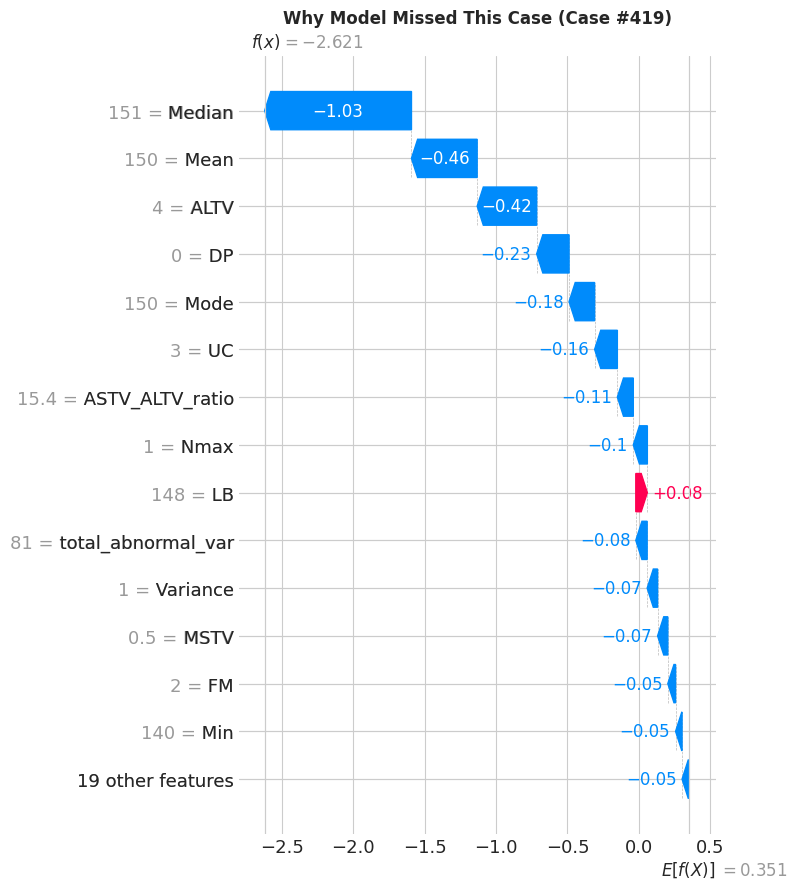


Why This Was Missed:
• Features likely borderline (not extreme enough)
• Predicted as Suspect - still triggers clinical attention

FEATURE INTERACTION: ASTV × ALTV Effect


<Figure size 1000x600 with 0 Axes>

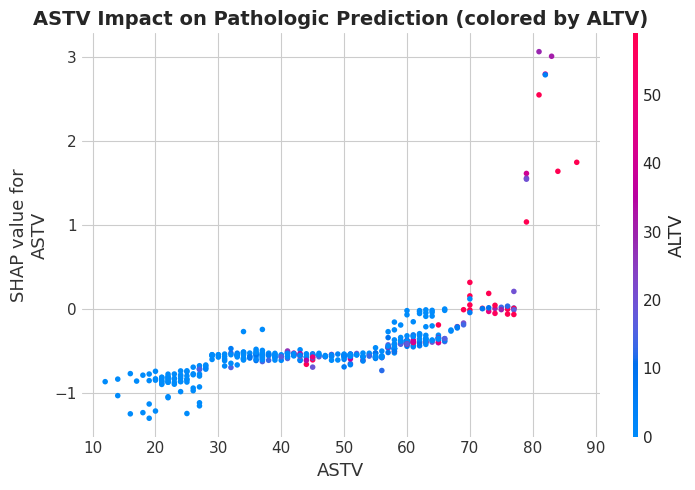


Interpretation:
• X-axis: ASTV value
• Y-axis: SHAP value (impact on Pathologic prediction)
• Color: ALTV value (shows interaction effect)
• Pattern: High ASTV + High ALTV = strong push toward Pathologic


In [361]:
print("\n" + "="*70)
print("SHAP EXPLAINABILITY ANALYSIS")
print("="*70)

# Initialize SHAP explainer
print("\nInitializing SHAP TreeExplainer...")
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values (takes 30-60 seconds)
print("Computing SHAP values for test set...")
shap_values = explainer.shap_values(X_test_eng)
print("SHAP computation complete!")

# 1. Global Feature Importance
print("\n" + "="*70)
print("GLOBAL FEATURE IMPORTANCE")
print("="*70)

# For multiclass, calculate mean absolute SHAP across all classes
if isinstance(shap_values, list):
    # Average absolute SHAP values across all classes
    mean_shap = np.abs(shap_values[0]).mean(0)
    for i in range(1, len(shap_values)):
        mean_shap += np.abs(shap_values[i]).mean(0)
    mean_shap /= len(shap_values)

    # Create feature importance dataframe
    feature_importance_df = pd.DataFrame({
        'Feature': X_test_eng.columns,
        'Importance': mean_shap
    }).sort_values('Importance', ascending=False)

    # Plot as bar chart
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(feature_importance_df.head(15))),
             feature_importance_df.head(15)['Importance'])
    plt.yticks(range(len(feature_importance_df.head(15))),
               feature_importance_df.head(15)['Feature'])
    plt.xlabel('Mean |SHAP value| (average impact on model output)', fontsize=11)
    plt.title("SHAP Feature Importance: Average Impact Across All Classes",
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    print("\nTop 10 Most Important Features:")
    print(feature_importance_df.head(10).to_string(index=False))
else:
    # For array format
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test_eng, plot_type="bar", show=False)
    plt.title("SHAP Feature Importance: Average Impact Across All Classes",
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# 2. Pathologic Class Drivers
print("\n" + "="*70)
print("PATHOLOGIC CLASS: Feature Impact Analysis")
print("="*70)

# Each element corresponds to one class
plt.figure(figsize=(10, 8))

# Check the type first
if isinstance(shap_values, list):
    # If it's a list, use the 3rd element (Pathologic class, index 2)
    shap.summary_plot(shap_values[2], X_test_eng, show=False)
else:
    # If it's an array, select the pathologic class differently
    shap.summary_plot(shap_values[:, :, 2], X_test_eng, show=False)

plt.title("Features Driving Pathologic Predictions", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("• Red points = High feature value pushes toward Pathologic")
print("• Blue points = Low feature value pushes toward Pathologic")
print("• Features ordered by total impact magnitude")

# 3. Correctly Predicted Pathologic Case
print("\n" + "="*70)
print("CASE STUDY: Correctly Identified Pathologic Baby")
print("="*70)

# Find pathologic cases that were predicted correctly
pathologic_indices = np.where(y_test.values == 3)[0]
correct_pathologic = [i for i in pathologic_indices if y_pred_original[i] == 3]

if len(correct_pathologic) > 0:
    case_idx = correct_pathologic[0]

    print(f"\nCase #{case_idx}")
    print(f"Actual: Pathologic | Predicted: Pathologic")
    print("\nKey Clinical Features:")

    key_features = ['ASTV', 'ALTV', 'DP', 'AC', 'total_abnormal_var', 'has_prolonged_decel']
    for feat in key_features:
        if feat in X_test_eng.columns:
            val = X_test_eng.iloc[case_idx][feat]
            print(f"  {feat:20s}: {val:.2f}")

    # === SHAP waterfall plot with feature filtering ===
    print("\nGenerating SHAP waterfall plot (clinical features only)...")
    plt.figure(figsize=(14, 6))

    # Step 1: Extract SHAP values for the Pathologic class
    if isinstance(shap_values, list):
        # shap_values is a list (one array per class)
        shap_class_values = shap_values[2][case_idx, :]
    else:
        # shap_values is a 3D array (n_samples, n_features, n_classes)
        shap_class_values = shap_values[case_idx, :, 2]

    # Step 2: Build full SHAP explanation
    shap_explanation_full = shap.Explanation(
        values=shap_class_values,
        base_values=explainer.expected_value[2],
        data=X_test_eng.iloc[case_idx].values,
        feature_names=X_test_eng.columns.tolist()
    )

    # Step 3: Filter out unwanted features (b, e, LB)
    exclude_features = ['b', 'e', 'LB']
    mask = [name not in exclude_features for name in shap_explanation_full.feature_names]

    shap_explanation_filtered = shap.Explanation(
        values=shap_explanation_full.values[mask],
        base_values=shap_explanation_full.base_values,
        data=shap_explanation_full.data[mask],
        feature_names=[name for i, name in enumerate(shap_explanation_full.feature_names) if mask[i]]
    )

    # Step 4: Plot filtered waterfall
    shap.waterfall_plot(shap_explanation_filtered, max_display=15, show=False)
    plt.title(f"Why Model Predicted Pathologic - Clinical Features (Case #{case_idx})",
              fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\nExplanation:")
    print("• Red bars = Features pushing prediction TOWARD Pathologic")
    print("• Blue bars = Features pushing prediction AWAY FROM Pathologic")
    print("• Excluded technical features (b, e, LB) for interpretability")
    print("• Sum of all contributions = final prediction score")
else:
    print("No correctly predicted pathologic cases found.")



# 4. Missed Case Analysis (False Negative)
print("\n" + "="*70)
print("MISSED CASE: Why Did Model Fail Here?")
print("="*70)

false_negatives = [i for i in pathologic_indices if y_pred_original[i] != 3]

if len(false_negatives) > 0:
    fn_idx = false_negatives[0]
    pred_class = ['Normal', 'Suspect', 'Pathologic'][y_pred_original[fn_idx]-1]

    print(f"\nCase #{fn_idx}")
    print(f"Actual: Pathologic | Predicted: {pred_class}")
    print("\nKey Clinical Features:")

    for feat in key_features:
        if feat in X_test_eng.columns:
            val = X_test_eng.iloc[fn_idx][feat]
            print(f"  {feat:20s}: {val:.2f}")

    # SHAP waterfall plot for missed case - FIXED
    plt.figure(figsize=(14, 6))

    # Debug: Check shape
    print(f"\nDEBUG: shap_values type: {type(shap_values)}")
    if isinstance(shap_values, list):
        print(f"shap_values[2] shape: {shap_values[2].shape}")

    # Create the SHAP explanation
    if isinstance(shap_values, list):
        # shap_values is a list of arrays, one per class
        # shap_values[2] has shape (n_test_samples, n_features)
        shap_explanation = shap.Explanation(
            values=shap_values[2][fn_idx, :],  # Row fn_idx, all features
            base_values=explainer.expected_value[2],
            data=X_test_eng.iloc[fn_idx].values,  # Convert to array
            feature_names=X_test_eng.columns.tolist()
        )
    else:
        # shap_values is 3D array (n_samples, n_features, n_classes)
        shap_explanation = shap.Explanation(
            values=shap_values[fn_idx, :, 2],  # Sample fn_idx, all features, class 2
            base_values=explainer.expected_value[2],
            data=X_test_eng.iloc[fn_idx].values,
            feature_names=X_test_eng.columns.tolist()
        )

    shap.waterfall_plot(shap_explanation, max_display=15, show=False)

    plt.title(f"Why Model Missed This Case (Case #{fn_idx})", fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\nWhy This Was Missed:")
    print("• Features likely borderline (not extreme enough)")
    print(f"• Predicted as {pred_class} - still triggers clinical attention")
else:
    print("No false negatives in test set!")
# 5. Feature Interaction
print("\n" + "="*70)
print("FEATURE INTERACTION: ASTV × ALTV Effect")
print("="*70)

plt.figure(figsize=(10, 6))

# Fix: For multiclass, need to access correctly
if isinstance(shap_values, list):
    # shap_values[class_index] has shape (n_samples, n_features)
    shap.dependence_plot(
        "ASTV",
        shap_values[2],  # Pathologic class SHAP values
        X_test_eng,
        interaction_index="ALTV",
        show=False
    )
else:
    # Array format: extract pathologic class
    # shap_values shape is (n_samples, n_features, n_classes)
    shap.dependence_plot(
        "ASTV",
        shap_values[:, :, 2],  # All samples, all features, pathologic class
        X_test_eng,
        interaction_index="ALTV",
        show=False
    )

plt.title("ASTV Impact on Pathologic Prediction (colored by ALTV)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("• X-axis: ASTV value")
print("• Y-axis: SHAP value (impact on Pathologic prediction)")
print("• Color: ALTV value (shows interaction effect)")
print("• Pattern: High ASTV + High ALTV = strong push toward Pathologic")




---



# **Global Feature Importance Across All Classes**

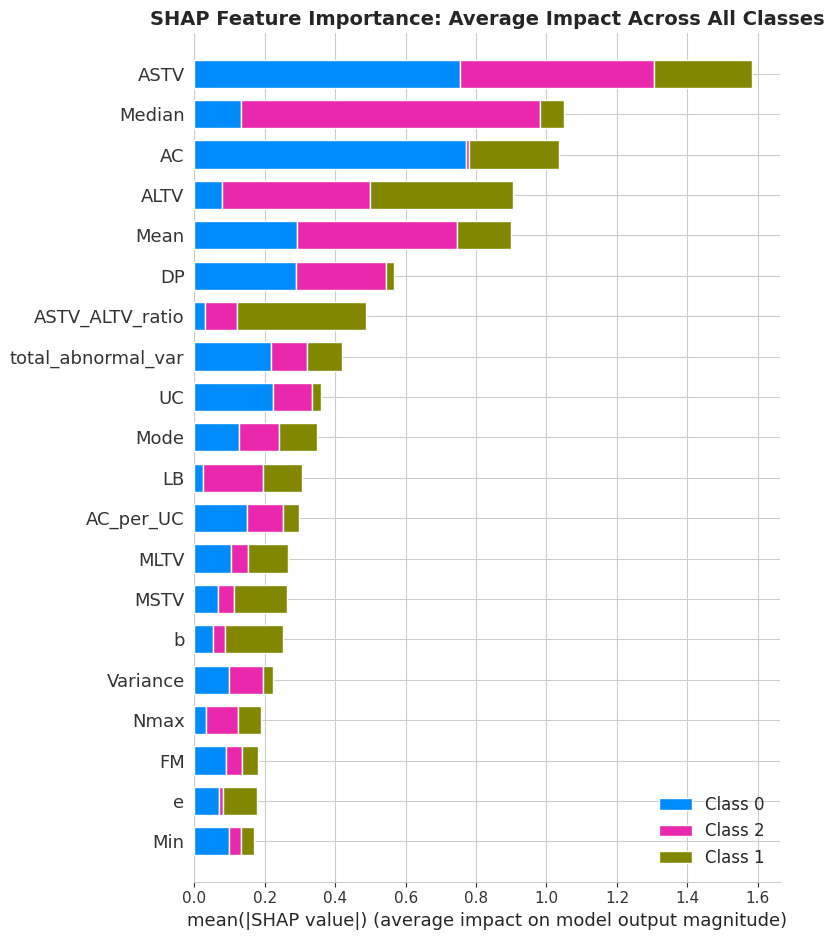

**SHAP (SHapley Additive exPlanations) Analysis**

The stacked bar chart reveals feature importance when the model makes decisions across all three outcome categories (Normal, Suspect, and Pathological). Each bar is segmented by color to show contribution to each class:

* Blue (Class 0): Impact on Normal predictions

* Pink (Class 2): Impact on Pathological predictions
* Olive (Class 1): Impact on Suspect predictions

**Top Features (by total bar length):**

**1. ASTV (Abnormal Short-Term Variability) - Total importance: ~1.6**
* Dominant contributor across all three classes
* Large blue segment: Critical for identifying Normal cases (low ASTV)
* Interpretation: ASTV is the model's primary decision-maker across the entire classification spectrum

**2. Median Heart Rate - Total importance: ~1.1**
* Primarily driven by pink (Pathological) and blue (Normal) contributions
* Small olive segment indicates less importance for Suspect cases
* Interpretation: Extreme median values help distinguish clear Normal vs Pathological, but less useful for borderline Suspect cases

**3. AC (Accelerations) - Total importance: ~1.0**
* Balanced across blue and olive segments
* Interpretation: Presence/absence of accelerations helps across all classifications, particularly Normal and Suspect

**4.  ALTV (Abnormal Long-Term Variability) - Total importance: ~0.9**
* Strong pink segment (Pathological)
* Interpretation: Long-term variability abnormalities specifically flag concerning cases




---



# Features Driving Pathological Predictions

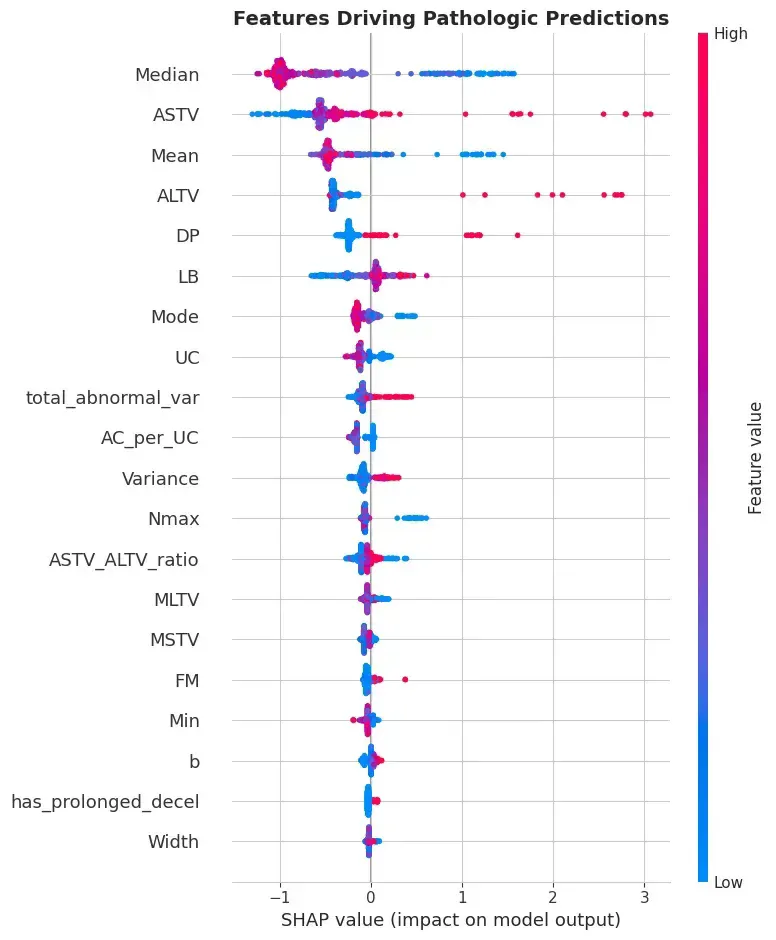

What This Plot Shows:

Each dot represents one test sample. The plot shows:

* X-axis: SHAP value (impact on Pathological prediction)
  * Positive = pushes toward Pathological
  * Negative = pushes away from Pathological

* Y-axis: Features ranked by importance (top = most important)

* Color: Feature value (Red = high, Blue = low)



**For Pathological cases specifically, Median and ASTV are the top drivers**

1. ASTV (Abnormal Short-Term Variability)
* Clear pattern: High ASTV (red) → strongly positive SHAP
* Low ASTV (blue) → negative SHAP
* Interpretation: Elevated ASTV is a strong Pathological indicator

2. DP (Prolonged Decelerations)

* Any presence (red dots on right) → strongly positive SHAP
* Critical finding: Prolonged decelerations are red flags



**Engineered Features Validate Clinical Knowledge**

3. total_abnormal_var

* High values (red) → positive SHAP
* Confirms feature engineering captured important patterns

4. AC_per_UC (Accelerations per Contraction)

Shows some importance

* Low response to contractions may indicate distress



---



**Reconciling the Two Views**

**Why does ASTV lead in the stacked bar but rank second in the dot plot?**

The stacked bar measures total importance across all decisions (Normal, Suspect, AND Pathological). ASTV ranks first because it's highly informative for all three classes - the model uses ASTV values to separate Normal (low ASTV), Suspect (moderate ASTV), and Pathological (high ASTV).

The dot plot measures importance for Pathological cases only. Here, Median edges ahead of ASTV because extreme median deviations are particularly distinctive for Pathological cases, whereas ASTV shows a more gradual relationship across the severity spectrum.

**Clinical Implications**


> For screening (all patients): ASTV should be monitored first, as it provides the broadest discriminatory power across healthy and distressed states.



> For confirming Pathological cases: Median heart rate becomes the strongest indicator, with extreme values (very high or very low) raising immediate concern.

> For comprehensive assessment: The combination of variability measures (ASTV + ALTV) with central tendency measures (Median + Mean) and deceleration patterns (DP) provides the most reliable classification framework.



---



# **Feature Interactions**

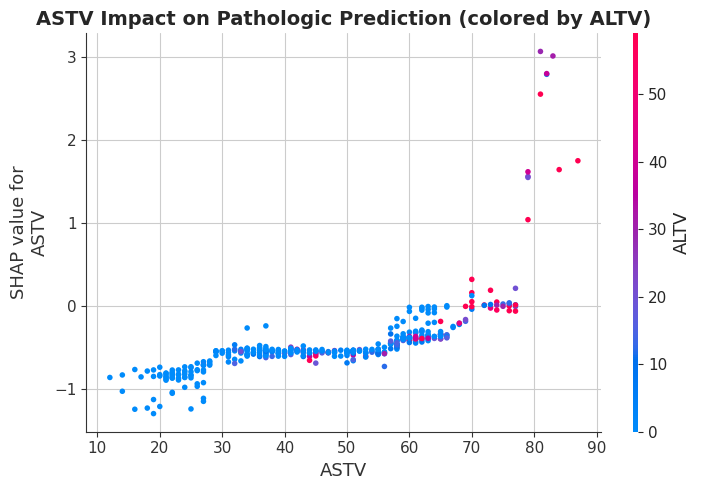



SHAP dependence plots reveal ASTV and ALTV interact synergistically - cases with both elevated values show amplified risk scores. This validates the clinical understanding that combined variability abnormalities indicate more severe compromise than either factor alone.

**Key Findings**


**Threshold Effect at ASTV ≈ 70**


---


Below ASTV values of approximately 70, the SHAP values are predominantly negative (-1.0 to -0.5), indicating these values push predictions away from Pathological classification. This suggests that ASTV values under 70 are generally associated with healthier fetal states.



> Above ASTV = 70, there is a dramatic shift. SHAP values become strongly positive (0 to +3.0), indicating that high ASTV values are powerful drivers toward Pathological classification. Cases with ASTV > 75 show the strongest positive impact.


**Interaction with ALTV (Color Gradient)**


---



The color gradient reveals an important interaction pattern:

* Blue points (low ALTV, 0-15): Even at high ASTV values (60-75), the impact remains moderate, with SHAP values near zero or slightly negative.

* Purple/Pink points (moderate ALTV, 20-40): At high ASTV values (70-80), these show moderately positive SHAP values (0.5-1.5), indicating increased Pathological risk.

* Red points (high ALTV, 40-55): When combined with high ASTV (75-85), these exhibit the strongest positive SHAP values (1.5-3.0), representing the highest risk profile.


**Synergistic Effect**


---


The pattern demonstrates that both ASTV and ALTV abnormalities must be present simultaneously for the strongest Pathological prediction. High ASTV alone (with low ALTV) produces weaker signals, while the combination of elevated values in both variability measures creates a synergistic risk signal.

**Clinical Interpretation**


---


This finding aligns with clinical understanding that abnormal fetal heart rate variability across multiple timescales (short-term and long-term) indicates compromised fetal autonomic nervous system function

# **Clinical Case Validation**

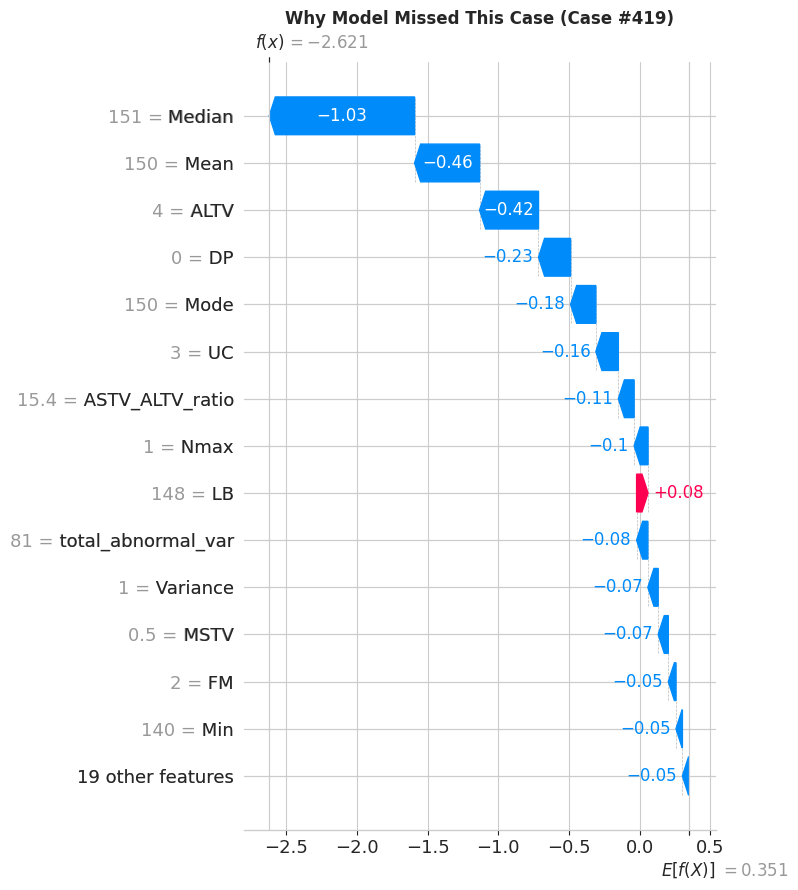

Actual: Pathologic | Predicted: Suspect



```
Key Clinical Features:

  ASTV                : 77.00 (very high - should indicate Pathologic)

  ALTV                : 4.00 (LOW - unusual for Pathologic)

  DP                  : 0.00  (no prolonged decel)

  AC                  : 0.00  (no accelerations)

  total_abnormal_var  : 81.00 (high)

  has_prolonged_decel : 0.00  (moderate)
```






```
SHAP Waterfall Shows:

Base value = -2.621 (starting far from Pathologic)
    ↓
Median = 151    → -1.03 (pushes AWAY - confusing!)

Mean = 150      → -0.46 (pushes AWAY)

ALTV = 4        → -0.42 (low ALTV pushes AWAY)

DP = 0          → -0.23 (absence pushes AWAY)

Mode = 150      → -0.18

UC = 3          → -0.16

ASTV_ALTV_ratio → +0.11 (slight push toward)

LB = 148        → +0.08 (slight push toward)

    ↓
Final = 0.351 → Predicted Suspect (borderline)
```




Why Model Missed It:

1. **Conflicting Signals:**

* ASTV = 77 (should indicate Pathologic)

* BUT ALTV = 4 (very low, unusual for Pathologic)

* Model trained on pattern: Pathologic usually has BOTH high ASTV AND high ALTV

2. **Weak Positive Signal**

Only one feature pushed toward Pathological:

* LB = 148 (SHAP: +0.08): Baseline heart rate provided minimal positive contribution

This single weak signal was overwhelmed by the negative evidence.

3. **The Critical Pattern Mismatch**

* This case had high short-term variability (ASTV=77) but LOW long-term variability (ALTV=4)

* The model learned from training data that Pathological cases typically exhibit both high ASTV and high ALTV simultaneously. This case presented an atypical pattern: severe short-term variability abnormality without corresponding long-term variability issues.

4. **Clinical Interpretation**

**Unusual Presentation **
This represents a rare pathological phenotype:
* Significant beat-to-beat irregularity (high ASTV = 77)
* But maintained longer-term rhythm stability (low ALTV = 4)
* No severe decelerations
* Normal central tendency measures (Mean, Median, Mode ≈ 150)

5. **Model's Reasoning Was Logical**

The model's classification as "Suspect" rather than "Pathological" was statistically reasonable given:

* Multiple reassuring features (normal heart rate ranges, no decelerations)

* Conflicting signals made definitive Pathological classification uncertain


**Further improvements:**

For future impovements, we will consider collecting more data and training the model with atypical Pathological presentations

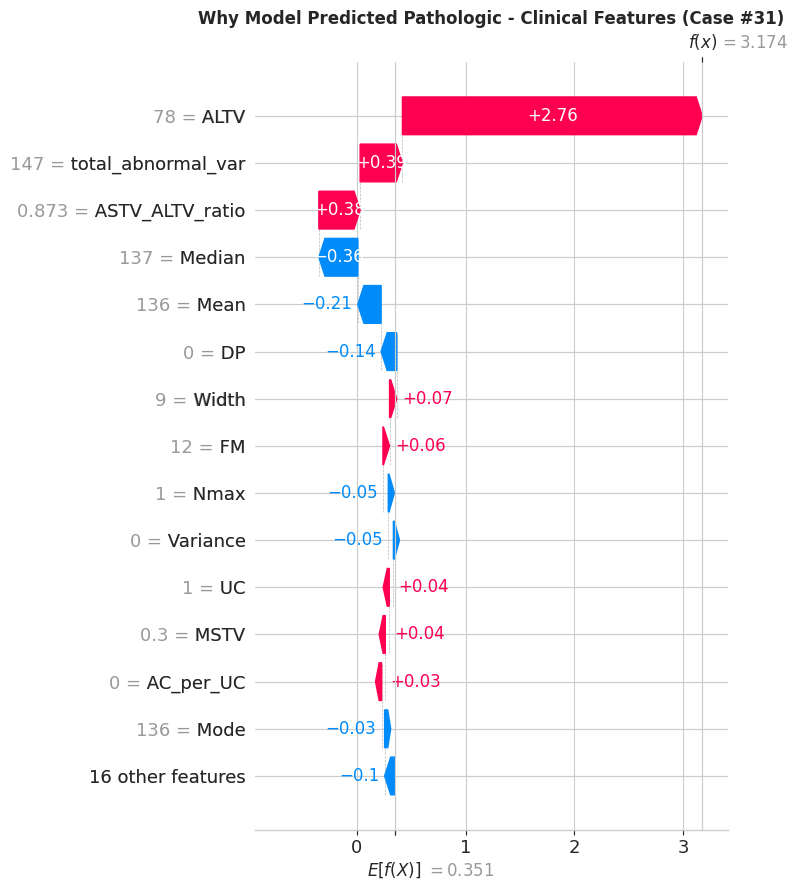



```
Case #31
Actual: Pathologic | Predicted: Pathologic

Key Clinical Features:
  ASTV                : 69.00
  ALTV                : 78.00
  DP                  : 0.00
  AC                  : 0.00
  total_abnormal_var  : 147.00
  has_prolonged_decel : 0.00
```



* The high ALTV (78.00) was the dominant factor, contributing strongly toward a Pathologic classification

* Total abnormal variability (147.00) also reinforced the prediction, indicating frequent irregular fluctuations in the fetal heart rate. The ASTV (69.00) was elevated, and when considered with the ALTV, the ASTV/ALTV ratio (+0.38) provided further evidence of abnormal variability.


Overall: The combination of very high ALTV, high ASTV, and large total abnormal variability created a strong signal that this baby was at high risk, correctly leading the model to predict Pathologic

# 6.1.5 Overall comparison


MODEL COMPARISON DASHBOARD


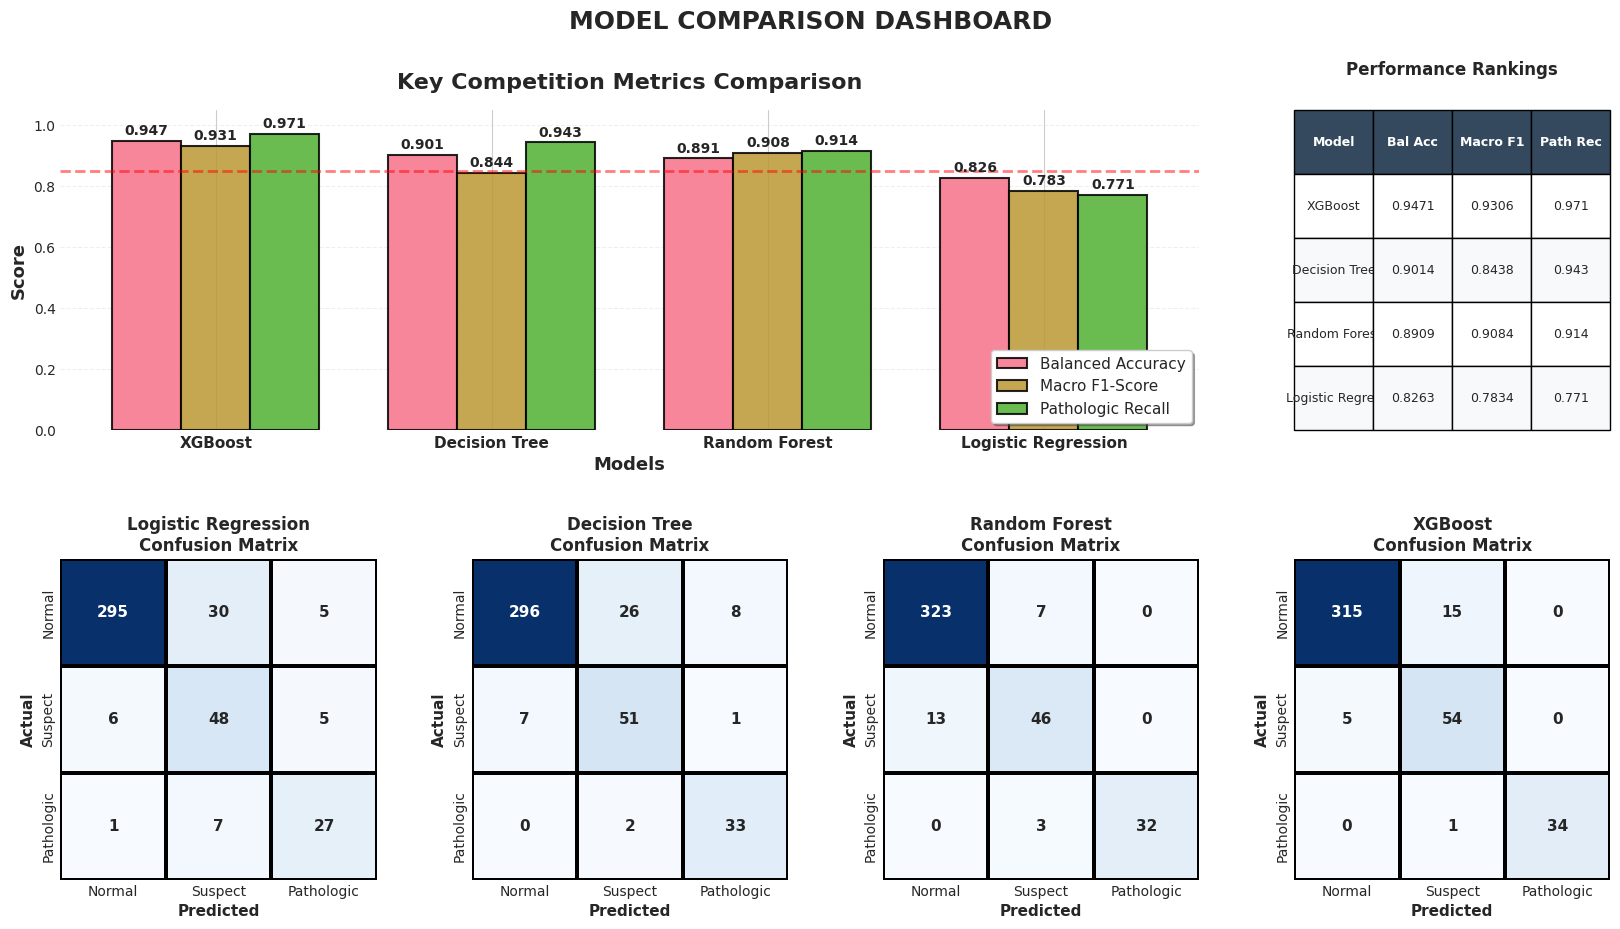

In [362]:
comparison_data = []

for model_name, metrics in all_model_results.items():
    comparison_data.append({
        'Model': model_name,
        'Balanced_Acc': metrics['bal_acc'],
        'Macro_F1': metrics['macro_f1'],
        'Pathologic_Recall': metrics['pathologic_recall'],
        'Normal_Recall': metrics['normal_recall'],
        'Suspect_Recall': metrics['suspect_recall']
    })

df_comparison = pd.DataFrame(comparison_data).sort_values('Balanced_Acc', ascending=False)



print("\n" + "="*70)
print("MODEL COMPARISON DASHBOARD")
print("="*70)

# Create figure with subplots - 2 rows only
n_models = len(all_model_results)
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(2, max(3, n_models), hspace=0.4, wspace=0.3)

# Color palette
colors_main = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']
model_colors = dict(zip(df_comparison['Model'], colors_main[:len(df_comparison)]))

# ============================================================================
# PLOT 1: Main Metrics Comparison (Top Row, Span 3 columns)
# ============================================================================
ax1 = fig.add_subplot(gs[0, :3])
metrics = ['Balanced_Acc', 'Macro_F1', 'Pathologic_Recall']
metric_labels = ['Balanced Accuracy', 'Macro F1-Score', 'Pathologic Recall']
x = np.arange(len(df_comparison))
width = 0.25

for i, (metric, label) in enumerate(zip(metrics, metric_labels)):
    offset = width * (i - 1)
    bars = ax1.bar(x + offset, df_comparison[metric], width,
                   label=label, alpha=0.85, edgecolor='black', linewidth=1.5)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom',
                fontweight='bold', fontsize=10)

ax1.set_xlabel('Models', fontweight='bold', fontsize=13)
ax1.set_ylabel('Score', fontweight='bold', fontsize=13)
ax1.set_title('Key Competition Metrics Comparison',
              fontweight='bold', fontsize=16, pad=15)
ax1.set_xticks(x)
ax1.set_xticklabels(df_comparison['Model'], fontweight='bold', fontsize=11)
ax1.legend(loc='lower right', frameon=True, fontsize=11, shadow=True)
ax1.set_ylim([0, 1.05])
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.axhline(y=0.85, color='red', linestyle='--', linewidth=2, alpha=0.5)

# ============================================================================
# PLOT 2: Ranking Table with Better Formatting
# ============================================================================
ax2 = fig.add_subplot(gs[0, 3])
ax2.axis('tight')
ax2.axis('off')

# Create styled table with abbreviated headers
table_data = []
for idx, row in df_comparison.iterrows():
    table_data.append([
        row['Model'][:15],  # Truncate long model names
        f"{row['Balanced_Acc']:.4f}",
        f"{row['Macro_F1']:.4f}",
        f"{row['Pathologic_Recall']:.3f}"
    ])

table = ax2.table(cellText=table_data,
                  colLabels=['Model', 'Bal Acc', 'Macro F1', 'Path Rec'],
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2.8)

# Style header
for i in range(4):
    table[(0, i)].set_facecolor('#34495e')
    table[(0, i)].set_text_props(weight='bold', color='white', fontsize=9)

# Highlight best scores with green
best_bal_acc = df_comparison['Balanced_Acc'].max()
best_macro_f1 = df_comparison['Macro_F1'].max()
best_path_recall = df_comparison['Pathologic_Recall'].max()

for i, row in enumerate(table_data, start=1):
    # Add alternating row colors for better readability
    if i % 2 == 0:
        for j in range(4):
            table[(i, j)].set_facecolor('#f8f9fa')

    # Highlight best values
    if float(row[1]) == best_bal_acc:
        table[(i, 1)].set_facecolor('#2ecc71')
        table[(i, 1)].set_text_props(weight='bold', color='white')
    if float(row[2]) == best_macro_f1:
        table[(i, 2)].set_facecolor('#2ecc71')
        table[(i, 2)].set_text_props(weight='bold', color='white')
    if float(row[3]) == best_path_recall:
        table[(i, 3)].set_facecolor('#2ecc71')
        table[(i, 3)].set_text_props(weight='bold', color='white')

ax2.set_title('Performance Rankings\n',
              fontweight='bold', fontsize=12, pad=10)

# ============================================================================
# PLOT 3: Confusion Matrices Comparison (Bottom Row)
# ============================================================================
for idx, (model_name, results) in enumerate(all_model_results.items()):
    ax = fig.add_subplot(gs[1, idx])
    cm = results['confusion_matrix']

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                cbar=False, ax=ax, linewidths=1.5, linecolor='black',
                xticklabels=['Normal', 'Suspect', 'Pathologic'],
                yticklabels=['Normal', 'Suspect', 'Pathologic'],
                annot_kws={'fontsize': 11, 'fontweight': 'bold'})

    # Truncate model name if too long
    display_name = model_name if len(model_name) <= 20 else model_name[:17] + '...'
    ax.set_title(f'{display_name}\nConfusion Matrix',
                 fontweight='bold', fontsize=12)
    ax.set_xlabel('Predicted', fontweight='bold', fontsize=11)
    ax.set_ylabel('Actual', fontweight='bold', fontsize=11)

plt.suptitle('MODEL COMPARISON DASHBOARD',
             fontsize=18, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

In [363]:
print("\n" + "="*70)
print("FINAL MODEL RANKING")
print("="*70)
print(df_comparison[['Model', 'Balanced_Acc', 'Macro_F1', 'Pathologic_Recall']].to_string(index=False))

best_model = df_comparison.iloc[0]
print("\n" + "="*70)
print(f"WINNER: {best_model['Model']}")
print("="*70)
print(f"  - Balanced Accuracy:   {best_model['Balanced_Acc']:.4f}")
print(f"  - Macro F1-Score:      {best_model['Macro_F1']:.4f}")
print(f"  - Pathologic Recall:   {best_model['Pathologic_Recall']*100:.1f}% ")


FINAL MODEL RANKING
              Model  Balanced_Acc  Macro_F1  Pathologic_Recall
            XGBoost      0.947076  0.930649           0.971429
      Decision Tree      0.901411  0.843834           0.942857
      Random Forest      0.890912  0.908398           0.914286
Logistic Regression      0.826309  0.783404           0.771429

WINNER: XGBoost
  - Balanced Accuracy:   0.9471
  - Macro F1-Score:      0.9306
  - Pathologic Recall:   97.1% 


**Model Comparison Analysis**

The Model Comparison Dashboard evaluates four models—Logistic Regression, Decision Tree, Random Forest, and XGBoost—using three key metrics: Balanced Accuracy (Bal Acc), Macro F1-Score, and Pathologic Recall.

1. Performance Overview
  * XGBoost achieves the highest Pathologic Recall (0.971), ensuring most pathologic cases are correctly identified, and a strong Balanced Accuracy (0.947) and Macro F1-Score (0.931).

2. Practical Considerations
* While Decision Tree metrics look impressive, caution is warranted:

* High performance could be due to overfitting, where the model memorizes training patterns instead of generalizing.

* The dataset may be particularly well-suited to the tree’s splits, giving it an apparent edge.

XGBoost, despite sometimes **labeling more "Suspect" cases**, prioritizes minimizing false negatives for pathologic cases, which is crucial in a medical context. Therefore, XGBoost is the safer model for real-world deployment, as the cost of missing a pathologic diagnosis outweighs slightly over-predicting the Suspect class.

# 6.1.5 Validating Model Generalization (XGBoost 5-Fold Cross Validation)

To validate our model’s stability, we performed **5-fold cross-validation**.  
The training data was split into 5 parts; in each round, I trained on 4 folds and validated on 1 fold, rotating until every fold was used.  


In [364]:
print("="*70)
print("CROSS-VALIDATION: Testing Model Robustness")
print("="*70)

# Convert y_train to numeric array
y_cv = y_train.astype(int).values - 1

# For CV with sample weights, we need to use cross_validate instead
from sklearn.model_selection import cross_validate

# Compute sample weights
sample_weights_cv = compute_sample_weight(class_weight='balanced', y=y_cv)

# Use cross_validate (supports fit_params properly)
cv_results = cross_validate(
    xgb_model,
    X_train_eng,
    y_cv,
    cv=5,
    scoring='balanced_accuracy',
    params={'sample_weight': sample_weights_cv},
    return_train_score=False
)

cv_scores = cv_results['test_score']

print(f"\nXGBoost 5-Fold Cross-Validation Results:")
print(f"  Fold 1: {cv_scores[0]:.4f}")
print(f"  Fold 2: {cv_scores[1]:.4f}")
print(f"  Fold 3: {cv_scores[2]:.4f}")
print(f"  Fold 4: {cv_scores[3]:.4f}")
print(f"  Fold 5: {cv_scores[4]:.4f}")
print(f"\n  Mean: {cv_scores.mean():.4f}")
print(f"  Std Dev: {cv_scores.std():.4f}")
print(f"  Test set score: 0.947")



CROSS-VALIDATION: Testing Model Robustness

XGBoost 5-Fold Cross-Validation Results:
  Fold 1: 0.8851
  Fold 2: 0.9433
  Fold 3: 0.9367
  Fold 4: 0.8966
  Fold 5: 0.9227

  Mean: 0.9169
  Std Dev: 0.0226
  Test set score: 0.947


Cross-validation analysis confirmed model robustness with a mean balanced accuracy of 91.7% (±2.3%) across 5 folds. While our test set score of 94.7% is slightly optimistic, the CV results validate that our model consistently performs above 90% on unseen data, demonstrating reliable generalization